# libraries

In [1]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import pingouin as pg
import seaborn as sns

import scipy
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

from IPython.display import Image
from category_encoders import BinaryEncoder
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline

seed = 123

In [2]:
# Loading the datset and  Visualization of the dataset (display the first 5 rows by default)
data = pd.read_csv("bank-full.csv", sep = ";")

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# General stats of categoric variables
data.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [4]:
# Converting the target from binary/categoric into binary/numeric
data['target'] = data.apply(lambda row: 1 if row["y"] == "yes" else 0, axis=1)
data.drop(["y"],axis=1,inplace=True)

## Basic infomation of the data

In [5]:
# Printing number of observations and variables, including the target
print(f"Number of clients:  {data.shape[0]}") # Number of observations
print(f"Number of variables:   {data.shape[1]} incl. target") # Number of variables or attributes

Number of clients:  45211
Number of variables:   17 incl. target



[0] Number of clients that haven't subscribed the term deposit: ... 39922
[1] Number of clients that have subscribed the term deposit: ....... 5289



,clients,%
0,39922,88.3
1,5289,11.7


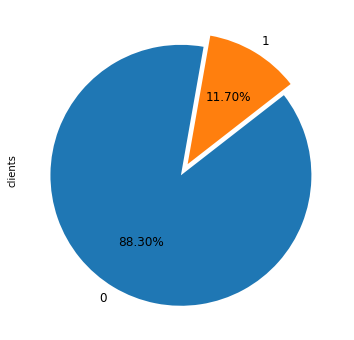

In [6]:
# How many clients have subscribed the term deposit and how many didn't?
absolut = data.target.value_counts().to_frame().rename(columns={"target":"clients"})
percent = (data.target.value_counts(normalize=True)*100).to_frame().rename(columns={"target":"%"})
data_bal = pd.concat([absolut,percent],axis=1).round(decimals=2)
print("")
print(f"[0] Number of clients that haven't subscribed the term deposit: ... {data.target.value_counts()[0]}")
print(f"[1] Number of clients that have subscribed the term deposit: ....... {data.target.value_counts()[1]}")
print("")
display(data_bal)
absolut.plot(kind='pie', subplots=True, autopct='%1.2f%%', 
             explode= (0.05, 0.05), startangle=80, 
             legend=False, fontsize=12, figsize=(14,6));

# Exploratory Data Analysis (EDA)

In [7]:
# Type of variables
data.dtypes.sort_values(ascending=True)

age           int64
previous      int64
pdays         int64
campaign      int64
duration      int64
day           int64
target        int64
balance       int64
loan         object
poutcome     object
month        object
default      object
education    object
marital      object
job          object
housing      object
contact      object
dtype: object

In [8]:
# Counting variables by type
data.dtypes.value_counts(ascending=True)

int64     8
object    9
dtype: int64

In [9]:
# Detecting missing values
display(data.isnull().sum())
print("")
print(f"Are there any missing values? {data.isnull().values.any()}")

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
dtype: int64


Are there any missing values? False


In [10]:
# Overview of shape, attributes, types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  target     45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


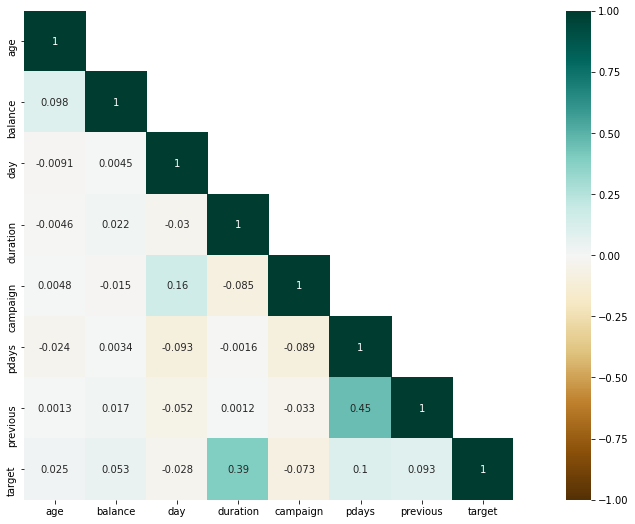

In [11]:
# Visualization of correlations (heatmap)
mask = np.triu(data.corr(), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(data.corr(), annot=True, vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);

In [12]:
# General stats of numeric variables
data.describe()

,age,balance,day,duration,campaign,pdays,previous,target
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [13]:
# General stats of categoric variables
data.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959


## Statistic description of numeric variables

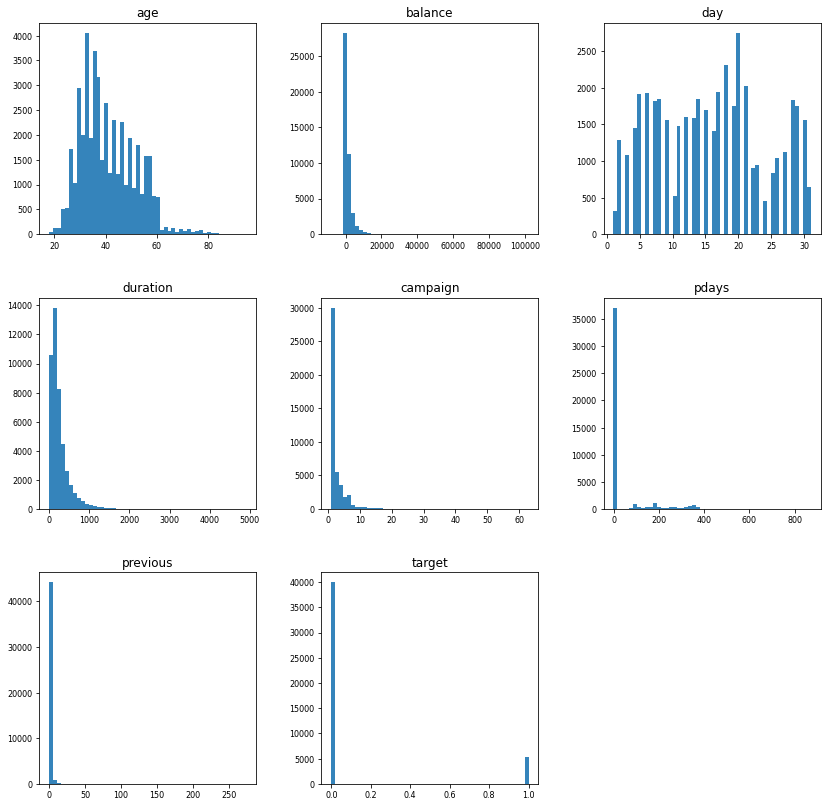

In [14]:
# Graphic visualization of the numeric distribution
data.hist(figsize=(14, 14), bins=50, xlabelsize=8, ylabelsize=8, alpha=0.9, grid=False)
plt.show()

## - age

Variable: 'age'
Discription: clients' age
Type of variable: int64
Type of distribution: continuous
Total observations: 45211
Missing values: 0
Unique values: 77
Min: 18
25%: 33
Median: 39.0
75%: 48
Max: 95
Mean: 40.93621021432837
Std dev: 10.61876204097542
Variance: 112.7581072828605
Skewness: 0.6847952047866451
Kurtosis: 0.31940232676995794



C:\Users\nanas\Anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nanas\Anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


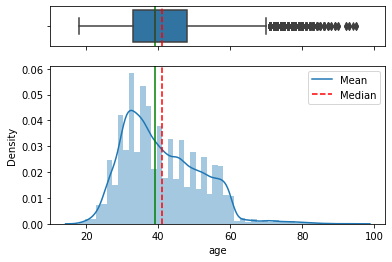

Percentiles 1%, 5%, 95%, 99%


0.01    23.0
0.05    27.0
0.95    59.0
0.99    71.0
Name: age, dtype: float64

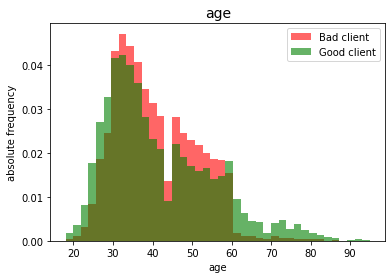

In [15]:
print("Variable: 'age'")
print("Discription: clients' age")
print(f"Type of variable: {data.age.dtype}")
print(f"Type of distribution: continuous")
print(f"Total observations: {data.age.shape[0]}")
print(f"Missing values: {data.age.isnull().sum()}")
print(f"Unique values: {data.age.nunique()}")
print(f"Min: {data.age.min()}")
print(f"25%: {int(data.age.quantile(q=[.25]).iloc[-1])}")
print(f"Median: {data.age.median()}")
print(f"75%: {int(data.age.quantile(q=[.75]).iloc[-1])}")
print(f"Max: {data.age.max()}")
print(f"Mean: {data.age.mean()}")
print(f"Std dev: {data.age.std()}")
print(f"Variance: {data.age.var()}")
print(f"Skewness: {scipy.stats.skew(data.age)}")
print(f"Kurtosis: {scipy.stats.kurtosis(data.age)}")
print("")

# Visualization of 'age'
age = data.age
np.array(age).mean()
np.median(age)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.5, 2)})
mean=np.array(age).mean()
median=np.median(age)

sns.boxplot(age, ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.distplot(age, ax=ax_hist)
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')

plt.legend({'Mean':mean,'Median':median})
ax_box.set(xlabel='')
plt.show()

# Calculus of percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.age.quantile(q=[.01, .05, .95, .99]))
print("")

# Visualization variable vs. target
age_0 = data[data.target == 0].iloc[:,:1]
age_1 = data[data.target == 1].iloc[:,:1]

a = np.array(age_0)
b = np.array(age_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, density=True, color="r", alpha = 0.6, label='Bad client')
plt.hist(b, bins=40, density=True, color="g", alpha = 0.6, label='Good client')
plt.legend(loc='upper right')
plt.title('age', fontsize=14)
plt.xlabel('age')
plt.ylabel('absolute frequency')
plt.show()

age_bins
Young     16.215446
Adult      9.845106
Senior    42.255892
Name: target, dtype: float64

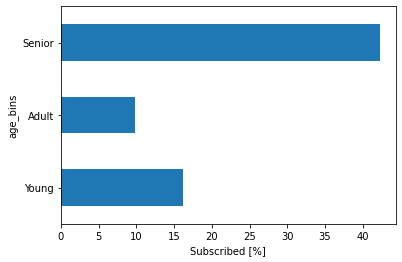

In [16]:
# display person that subscribe
data['age_bins'] = pd.cut(data['age'], bins = [data['age'].min(), 30, 60, data['age'].max()], 
                  labels=['Young', 'Adult', 'Senior'])

group_age_target = data.groupby(['age_bins'])['target'].mean().multiply(100)

display(group_age_target)
print("")

# Display graph
group_age_target.plot.barh()
plt.xlabel('Subscribed [%]');

## - pdays

Variable: 'pdays'
Discription: number of days that passed by after the client was last contacted from a previous campaign
Type of variable: int64
Type of distribution: discrete
Total observations: 45211
Missing values: 0
Unique values: 559
Min: -1
25%: -1
Median: -1.0
75%: -1
Max: 871
Mean: 40.19782796222158
Std dev: 100.12874599059835
Variance: 10025.765773649764
Skewness: 2.615628689259389
Kurtosis: 6.934295545084991



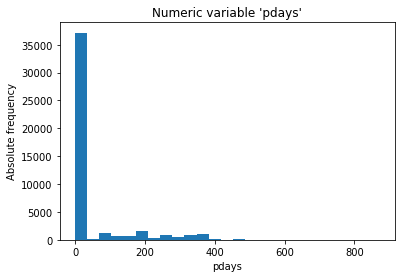

Percentiles 1%, 5%, 95%, 99%


0.01     -1.0
0.05     -1.0
0.95    317.0
0.99    370.0
Name: pdays, dtype: float64

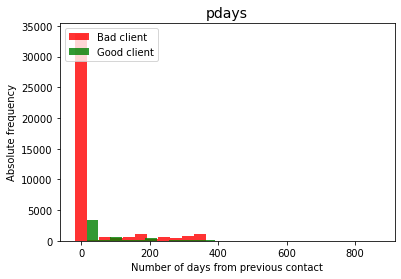

In [17]:
print("Variable: 'pdays'")
print("Discription: number of days that passed by after the client was last contacted from a previous campaign")
print(f"Type of variable: {data.pdays.dtype}")
print(f"Type of distribution: discrete")
print(f"Total observations: {data.pdays.shape[0]}")
print(f"Missing values: {data.pdays.isnull().sum()}")
print(f"Unique values: {data.pdays.nunique()}")
print(f"Min: {data.pdays.min()}")
print(f"25%: {int(data.pdays.quantile(q=[.25]).iloc[-1])}")
print(f"Median: {data.pdays.median()}")
print(f"75%: {int(data.pdays.quantile(q=[.75]).iloc[-1])}")
print(f"Max: {data.pdays.max()}")
print(f"Mean: {data.pdays.mean()}")
print(f"Std dev: {data.pdays.std()}")
print(f"Variance: {data.pdays.var()}")
print(f"Skewness: {scipy.stats.skew(data.pdays)}")
print(f"Kurtosis: {scipy.stats.kurtosis(data.pdays)}")
print("")

# Visualization of 'pdays'
plt.hist(data.pdays, bins=25)
plt.title('Numeric variable \'pdays\'', fontsize=12)
plt.xlabel('pdays')
plt.ylabel('Absolute frequency')
plt.show()

# Calculus percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.pdays.quantile(q=[.01, .05, .95, .99]))
print("")

# Visualization variable vs. target
pdays_0 = data[data.target == 0].iloc[:,13:14]
pdays_1 = data[data.target == 1].iloc[:,13:14]

a = np.array(pdays_0)
b = np.array(pdays_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=25, density=False, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper left')
plt.title('pdays', fontsize=14)
plt.xlabel('Number of days from previous contact')
plt.ylabel('Absolute frequency')
plt.show()

Median: -1.0


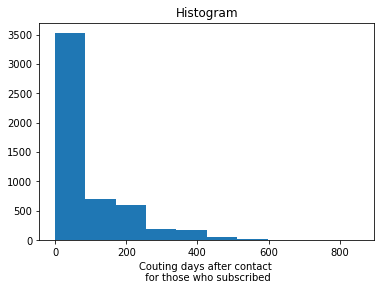

In [18]:
dummy = data.loc[(data['pdays']!=871) & (data['target'] == 1), 'pdays']
print('Median: {:.2}'.format(dummy.median()))
dummy.hist().grid(False)
plt.title('Histogram')
plt.xlabel('Couting days after contact \n for those who subscribed');

## - previous

Variable: 'previous'
Discription: number of contacts performed before this campaign and for this client
Type of variable: int64
Type of distribution: discrete
Total observations: 45211
Missing values: 0
Unique values: 41
Min: 0
25%: 0
Median: 0.0
75%: 0
Max: 275
Mean: 0.5803233726305546
Std dev: 2.3034410449312213
Variance: 5.305840647473837
Skewness: 41.84506608797322
Kurtosis: 4506.362117674052



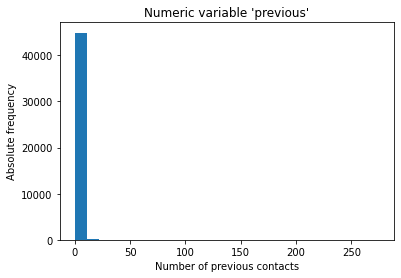

Percentiles 1%, 5%, 95%, 99%


0.01    0.0
0.05    0.0
0.95    3.0
0.99    8.9
Name: previous, dtype: float64

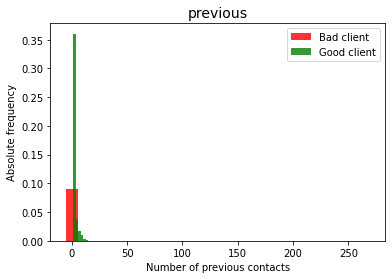

In [19]:
print("Variable: 'previous'")
print("Discription: number of contacts performed before this campaign and for this client")
print(f"Type of variable: {data.previous.dtype}")
print(f"Type of distribution: discrete")
print(f"Total observations: {data.previous.shape[0]}")
print(f"Missing values: {data.previous.isnull().sum()}")
print(f"Unique values: {data.previous.nunique()}")
print(f"Min: {data.previous.min()}")
print(f"25%: {int(data.previous.quantile(q=[.25]).iloc[-1])}")
print(f"Median: {data.previous.median()}")
print(f"75%: {int(data.previous.quantile(q=[.75]).iloc[-1])}")
print(f"Max: {data.previous.max()}")
print(f"Mean: {data.previous.mean()}")
print(f"Std dev: {data.previous.std()}")
print(f"Variance: {data.previous.var()}")
print(f"Skewness: {scipy.stats.skew(data.previous)}")
print(f"Kurtosis: {scipy.stats.kurtosis(data.previous)}")
print("")

# Visualization of the numeric variable 'pdays'
plt.hist(data.previous, bins=25)
plt.title('Numeric variable \'previous\'', fontsize=12)
plt.xlabel('Number of previous contacts')
plt.ylabel('Absolute frequency')
plt.show()

# Cslculus of percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.previous.quantile(q=[.01, .05, .95, .99]))
print("")

# Visualization variable vs. target
previous_0 = data[data.target == 0].iloc[:,14:15]
previous_1 = data[data.target == 1].iloc[:,14:15]

a = np.array(previous_0)
b = np.array(previous_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=True, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=25, density=True, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper right')
plt.title('previous', fontsize=14)
plt.xlabel('Number of previous contacts')
plt.ylabel('Absolute frequency')
plt.show()

How many people were previously contacted? ................. 8257
How many people were contacted 7 times? .................... 205
How many people were previously contacted with sucess? ..... 4901
How many people were previously contacted with failure? .... 1840


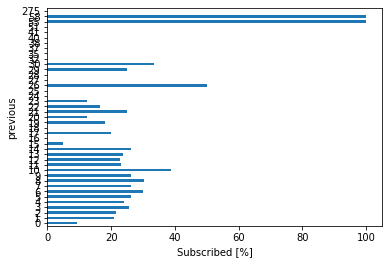

In [20]:
# subscribe term deposit
group = data.groupby(['previous'])['target'].mean().multiply(100)
group.plot.barh()
plt.xlabel('Subscribed [%]');

print('How many people were previously contacted? ................. {}'.format(data.loc[data['previous']!=0].shape[0]))
print('How many people were contacted 7 times? .................... {}'.format(data.loc[data['previous']==7, 'previous'].count()))
print('How many people were previously contacted with sucess? ..... {}'.format(data.poutcome.value_counts()[1]))
print('How many people were previously contacted with failure? .... {}'.format(data.poutcome.value_counts()[2]))

## - Balance

Designation,Value
Variable,balance
Description,the average yearly balance in euro
Type of variable,int64
Type of distribution,discrete
Total observations,45211
Missing values,0
Unique values,7168
Min,-8019
25%,72
Median,448


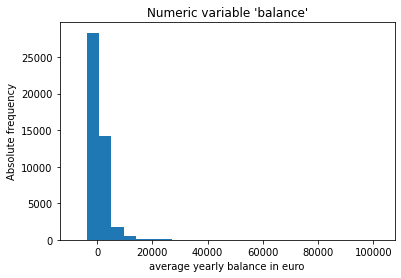

Percentiles 1%, 5%, 95%, 99%


0.01     -627.0
0.05     -172.0
0.95     5768.0
0.99    13164.9
Name: balance, dtype: float64

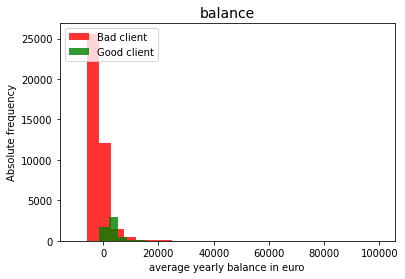

In [21]:
# General stats description
stats_balance = {'Designation': ['Value'],
            'Variable': 'balance',
            'Description': 'the average yearly balance in euro',
            'Type of variable': data.balance.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.balance.shape[0],
            'Missing values': data.balance.isnull().sum(),
            'Unique values': data.balance.nunique(),
            'Min': data.balance.min(),
            '25%': int(data.balance.quantile(q=[.25]).iloc[-1]),
            'Median': data.balance.median(),
            '75%': int(data.balance.quantile(q=[.75]).iloc[-1]),
            'Max': data.balance.max(),
            'Mean': data.balance.mean(),
            'Std dev': data.balance.std(),
            'Variance': data.balance.var(),
            'Skewness': scipy.stats.skew(data.balance),
            'Kurtosis': scipy.stats.kurtosis(data.balance)
           }

st_balance = pd.DataFrame(stats_balance, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_balance.set_index("Designation", inplace=True)
results = st_balance.T
resultsT = st_balance
display(results)

# Visualization of the numeric variable 'balance'
plt.hist(data.balance, bins=25)
plt.title('Numeric variable \'balance\'', fontsize=12)
plt.xlabel('average yearly balance in euro')
plt.ylabel('Absolute frequency')
plt.show()

# Calculus of percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.balance.quantile(q=[.01, .05, .95, .99]))

# Visualization variable vs. target
balance_0 = data[data.target == 0].iloc[:,5:6]
balance_1 = data[data.target == 1].iloc[:,5:6]

a = np.array(balance_0)
b = np.array(balance_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=25, density=False, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper left')
plt.title('balance', fontsize=14)
plt.xlabel('average yearly balance in euro')
plt.ylabel('Absolute frequency')
plt.show()

## - day

Designation,Value
Variable,day
Description,The day of the week the last contact was made
Type of variable,int64
Type of distribution,discrete
Total observations,45211
Missing values,0
Unique values,31
Min,1
25%,8
Median,16


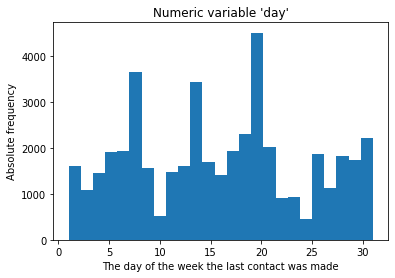

Percentiles 1%, 5%, 95%, 99%


0.01     2.0
0.05     3.0
0.95    29.0
0.99    31.0
Name: day, dtype: float64

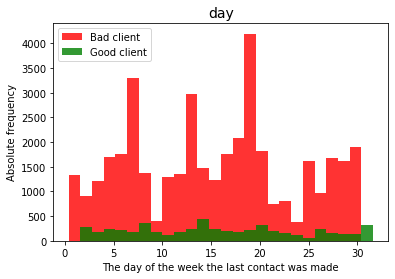

Median: 1.5e+01


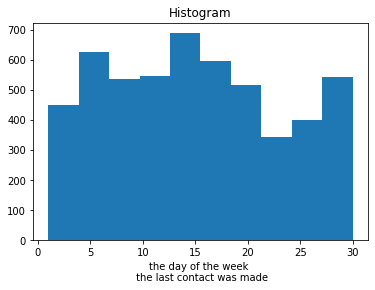

In [22]:
# General stats description
stats_day = {'Designation': ['Value'],
            'Variable': 'day',
            'Description': 'The day of the week the last contact was made ',
            'Type of variable': data.day.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.day.shape[0],
            'Missing values': data.day.isnull().sum(),
            'Unique values': data.day.nunique(),
            'Min': data.day.min(),
            '25%': int(data.day.quantile(q=[.25]).iloc[-1]),
            'Median': data.day.median(),
            '75%': int(data.day.quantile(q=[.75]).iloc[-1]),
            'Max': data.day.max(),
            'Mean': data.day.mean(),
            'Std dev': data.day.std(),
            'Variance': data.day.var(),
            'Skewness': scipy.stats.skew(data.day),
            'Kurtosis': scipy.stats.kurtosis(data.day)
           }

st_day = pd.DataFrame(stats_day, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_day.set_index("Designation", inplace=True)
results = st_day.T
resultsT = st_day
display(results)

# Visualization of the numeric variable 'day'
plt.hist(data.day, bins=25)
plt.title('Numeric variable \'day\'', fontsize=12)
plt.xlabel('The day of the week the last contact was made')
plt.ylabel('Absolute frequency')
plt.show()

# Calculus of percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.day.quantile(q=[.01, .05, .95, .99]))

# Visualization variable vs. target
day_0 = data[data.target == 0].iloc[:,9:10]
day_1 = data[data.target == 1].iloc[:,9:10]

a = np.array(day_0)
b = np.array(day_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=25, density=False, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper left')
plt.title('day', fontsize=14)
plt.xlabel('The day of the week the last contact was made')
plt.ylabel('Absolute frequency')
plt.show()

# Subscribe
dummy = data.loc[(data['day']!=31) & (data['target'] == 1), 'day']
print('Median: {:.2}'.format(dummy.median()))
dummy.hist().grid(False)
plt.title('Histogram')
plt.xlabel('the day of the week \n the last contact was made');

## - Duration

Designation,Value
Variable,age
Description,the last contact duration
Type of variable,int64
Type of distribution,discrete
Total observations,45211
Missing values,0
Unique values,1573
Min,0
25%,103
Median,180


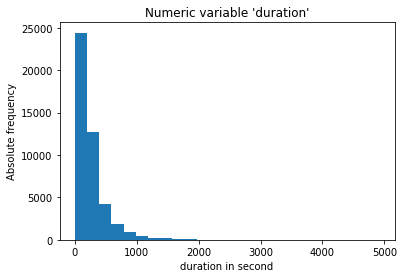

Percentiles 1%, 5%, 95%, 99%


0.01      11.0
0.05      35.0
0.95     751.0
0.99    1269.0
Name: duration, dtype: float64

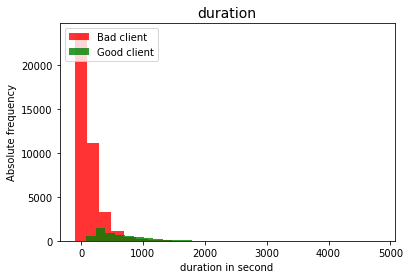

Median: 4.3e+02


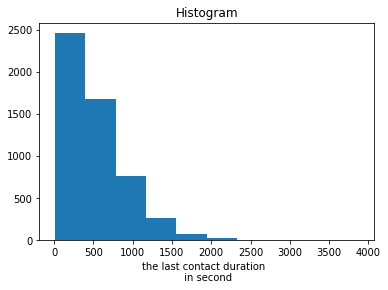

In [23]:
# General stats description
stats_duration = {'Designation': ['Value'],
            'Variable': 'age',
            'Description': 'the last contact duration ',
            'Type of variable': data.duration.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.duration.shape[0],
            'Missing values': data.duration.isnull().sum(),
            'Unique values': data.duration.nunique(),
            'Min': data.duration.min(),
            '25%': int(data.duration.quantile(q=[.25]).iloc[-1]),
            'Median': data.duration.median(),
            '75%': int(data.duration.quantile(q=[.75]).iloc[-1]),
            'Max': data.duration.max(),
            'Mean': data.duration.mean(),
            'Std dev': data.duration.std(),
            'Variance': data.duration.var(),
            'Skewness': scipy.stats.skew(data.duration),
            'Kurtosis': scipy.stats.kurtosis(data.duration)
           }
st_duration = pd.DataFrame(stats_duration, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_duration.set_index("Designation", inplace=True)

results = st_duration.T
resultsT = st_duration
display(results)

# Visualization of the numeric variable 'duration'
plt.hist(data.duration, bins=25)
plt.title('Numeric variable \'duration\'', fontsize=12)
plt.xlabel('duration in second')
plt.ylabel('Absolute frequency')
plt.show()

# Calculus of percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.duration.quantile(q=[.01, .05, .95, .99]))

# Visualization variable vs. target
duration_0 = data[data.target == 0].iloc[:,11:12]
duration_1 = data[data.target == 1].iloc[:,11:12]

a = np.array(duration_0)
b = np.array(duration_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=25, density=False, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper left')
plt.title('duration', fontsize=14)
plt.xlabel('duration in second')
plt.ylabel('Absolute frequency')
plt.show()

# subscribe
dummy = data.loc[(data['duration']!=31) & (data['target'] == 1), 'duration']
print('Median: {:.2}'.format(dummy.median()))
dummy.hist().grid(False)
plt.title('Histogram')
plt.xlabel('the last contact duration  \n in second');

## - Campaign

Designation,Value
Variable,age
Description,the last contact duration
Type of variable,int64
Type of distribution,discrete
Total observations,45211
Missing values,0
Unique values,48
Min,1
25%,1
Median,2


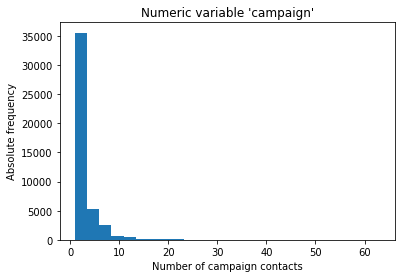

Percentiles 1%, 5%, 95%, 99%


0.01     1.0
0.05     1.0
0.95     8.0
0.99    16.0
Name: campaign, dtype: float64

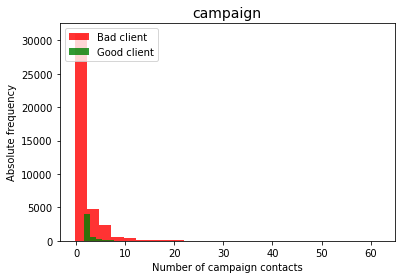

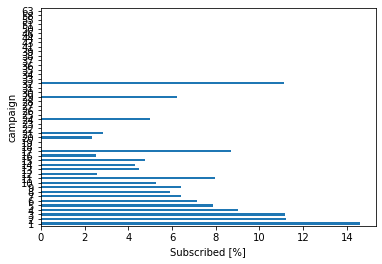

In [24]:
# General stats description
stats_campaign = {'Designation': ['Value'],
            'Variable': 'age',
            'Description': 'the last contact duration ',
            'Type of variable': data.campaign.dtype,
            'Type of distribution': 'discrete',
            'Total observations': data.campaign.shape[0],
            'Missing values': data.campaign.isnull().sum(),
            'Unique values': data.campaign.nunique(),
            'Min': data.campaign.min(),
            '25%': int(data.campaign.quantile(q=[.25]).iloc[-1]),
            'Median': data.campaign.median(),
            '75%': int(data.campaign.quantile(q=[.75]).iloc[-1]),
            'Max': data.campaign.max(),
            'Mean': data.campaign.mean(),
            'Std dev': data.campaign.std(),
            'Variance': data.campaign.var(),
            'Skewness': scipy.stats.skew(data.campaign),
            'Kurtosis': scipy.stats.kurtosis(data.campaign)
           }
st_campaign = pd.DataFrame(stats_campaign, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Type of distribution',
                                     'Total observations',
                                     'Missing values',
                                     'Unique values',
                                     'Min',
                                     '25%',
                                     'Median',
                                     '75%',
                                     'Max',
                                     'Mean',
                                     'Std dev',
                                     'Variance',
                                     'Skewness',
                                     'Kurtosis'
                                        ])
st_campaign.set_index("Designation", inplace=True)

results = st_campaign.T
resultsT = st_campaign
display(results)

# Visualization of the numeric 'campaign'
emp_var_rate = data.campaign
np.array(emp_var_rate).mean()
np.median(emp_var_rate)

#f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.5, 2)})
mean=np.array(emp_var_rate).mean()
median=np.median(emp_var_rate)

#sns.boxplot(emp_var_rate, ax=ax_box)
#ax_box.axvline(mean, color='r', linestyle='--')
#ax_box.axvline(median, color='g', linestyle='-')

#sns.distplot(emp_var_rate, ax=ax_hist)
#ax_hist.axvline(mean, color='r', linestyle='--')
#ax_hist.axvline(median, color='g', linestyle='-')

#plt.legend({'Mean':mean,'Median':median})
#ax_box.set(xlabel='');

# Visualization of the numeric variable 'campaign'
plt.hist(data.campaign, bins=25)
plt.title('Numeric variable \'campaign\'', fontsize=12)
plt.xlabel('Number of campaign contacts')
plt.ylabel('Absolute frequency')
plt.show()

# Calculus of percentiles 1%, 5%, 95% and 99%
print("Percentiles 1%, 5%, 95%, 99%")
display(data.campaign.quantile(q=[.01, .05, .95, .99]))

# Visualization variable vs. target
campaign_0 = data[data.target == 0].iloc[:,12:13]
campaign_1 = data[data.target == 1].iloc[:,12:13]

a = np.array(campaign_0)
b = np.array(campaign_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=25, density=False, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=25, density=False, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper left')
plt.title('campaign', fontsize=14)
plt.xlabel('Number of campaign contacts')
plt.ylabel('Absolute frequency')
plt.show()

# subscribe
group = data.groupby(['campaign'])['target'].mean().multiply(100)
group.plot.barh()
plt.xlabel('Subscribed [%]');

# Categoric variables 
## - job

Variable: 'job'
Discription: type of job
Type of variable: object
Total observations: 45211
Unique values: 12
List of unique values: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']



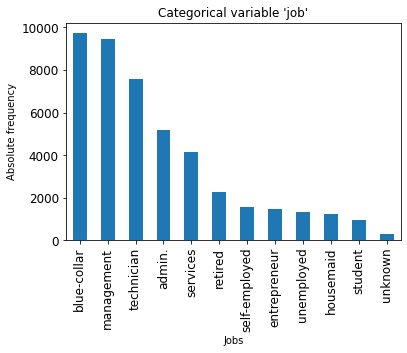

,Freq abs,percent %
blue-collar,9732,21.53
management,9458,20.92
technician,7597,16.80
admin.,5171,11.44
services,4154,9.19
retired,2264,5.01
self-employed,1579,3.49
entrepreneur,1487,3.29
unemployed,1303,2.88
housemaid,1240,2.74


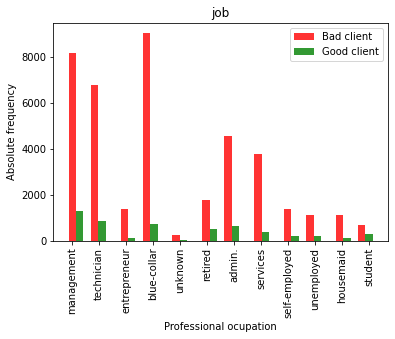

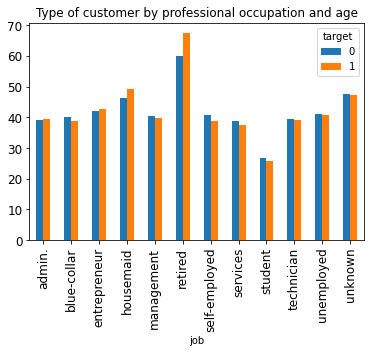

In [25]:
print("Variable: 'job'")
print("Discription: type of job")
print(f"Type of variable: {data.job.dtype}")
print(f"Total observations: {data.job.shape[0]}")
print(f"Unique values: {data.job.nunique()}")
print(f"List of unique values: {data.job.unique()}")
print("")

# Visualization of the categoric 'job'
data_count = data['job'].value_counts().plot(kind='bar', figsize=(6,4), fontsize=12)
plt.title('Categorical variable \'job\'', fontsize=12)
plt.xlabel('Jobs')
plt.ylabel('Absolute frequency')
plt.show()

# Number of observations by class
num_obs = data.job.value_counts()
num_o = pd.DataFrame(num_obs)
num_o.rename(columns={"job":"Freq abs"}, inplace=True)
num_o_pc = (data.job.value_counts(normalize=True) * 100).round(decimals=2)
num_obs_pc = pd.DataFrame(num_o_pc)
num_obs_pc.rename(columns={"job":"percent %"}, inplace=True)
n_obs = pd.concat([num_o,num_obs_pc], axis=1)
display(n_obs)

# Graph 'job' vs. 'target'
job_0 = data[data.target == 0].iloc[:,1:2]
job_1 = data[data.target == 1].iloc[:,1:2]

a = np.array(job_0)
b = np.array(job_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper right')
plt.title('job', fontsize=12)
plt.xlabel('Professional ocupation')
plt.xticks(rotation='vertical')
plt.ylabel('Absolute frequency')
plt.show()

# Graph: type of customer by professional occupation and age
#Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="job",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["job"], 
                       ascending=True).plot(kind="bar", 
                                             title=("Type of customer by professional occupation and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

## - marital

Variable: 'marital'
Discription: Marital situation
Type of variable: object
Total observations: 45211
Unique values: 3
List of unique values: ['married' 'single' 'divorced']



,Freq abs,percent %
married,27214,60.19
single,12790,28.29
divorced,5207,11.52


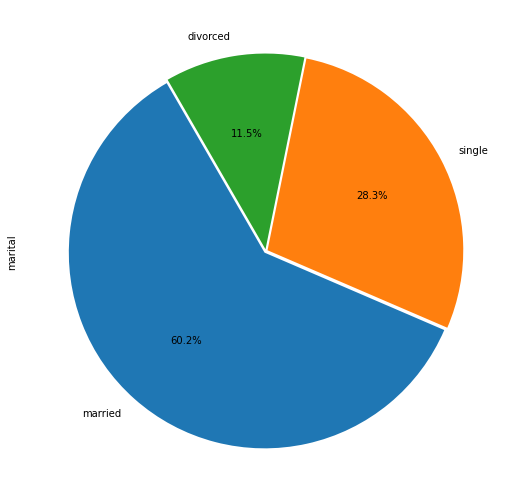

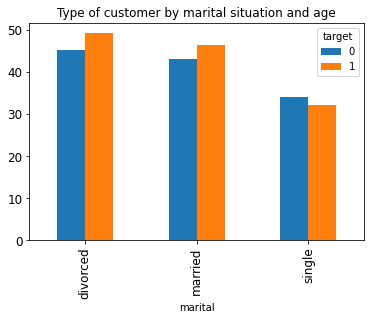

In [26]:
print("Variable: 'marital'")
print("Discription: Marital situation")
print(f"Type of variable: {data.marital.dtype}")
print(f"Total observations: {data.marital.shape[0]}")
print(f"Unique values: {data.marital.nunique()}")
print(f"List of unique values: {data.marital.unique()}")
print("")

# Graph "pie"
data['marital'].value_counts(dropna=False).plot(kind='pie', figsize=(14,9),
                                              explode = (0.01, 0.01, 0.01),
                                              autopct='%1.1f%%',
                                              startangle=120);

# Number of observations by class
marital_obs = data.marital.value_counts()
marital_o = pd.DataFrame(marital_obs)
marital_o.rename(columns={"marital":"Freq abs"}, inplace=True)
marital_o_pc = (data.marital.value_counts(normalize=True) * 100).round(decimals=2)
marital_obs_pc = pd.DataFrame(marital_o_pc)
marital_obs_pc.rename(columns={"marital":"percent %"}, inplace=True)
marital_obs = pd.concat([marital_o,marital_obs_pc], axis=1)
display(marital_obs)

# Graph: Type of customer by marital situation and age
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="marital",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["marital"], 
                       ascending=True).plot(kind="bar", 
                                             title=("Type of customer by marital situation and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);


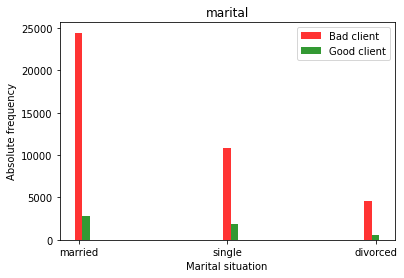

In [27]:
# Graph 'marital' vs. 'target'
marital_0 = data[data.target == 0].iloc[:,2:3]
marital_1 = data[data.target == 1].iloc[:,2:3]

a = np.array(marital_0)
b = np.array(marital_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper right')
plt.title('marital', fontsize=12)
plt.xlabel('Marital situation')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

## - education

Variable: 'education'
Discription: Education level
Type of variable: object
Total observations: 45211
Unique values: 4
List of unique values: ['tertiary' 'secondary' 'unknown' 'primary']



,Freq abs,percent %
secondary,23202,51.32
tertiary,13301,29.42
primary,6851,15.15
unknown,1857,4.11


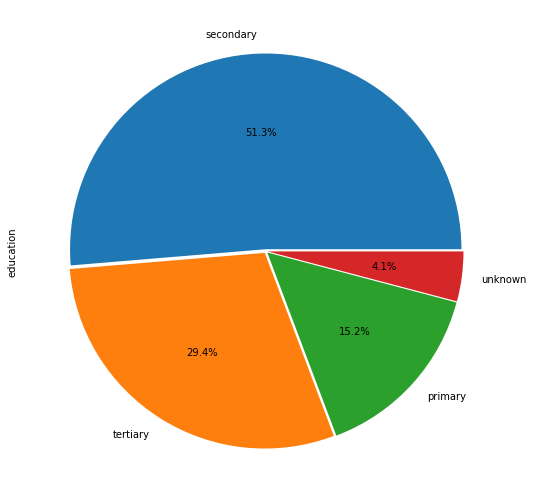

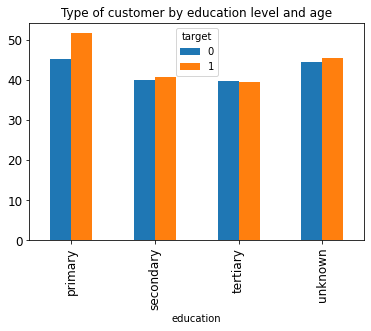

In [28]:
print("Variable: 'education'")
print("Discription: Education level")
print(f"Type of variable: {data.education.dtype}")
print(f"Total observations: {data.education.shape[0]}")
print(f"Unique values: {data.education.nunique()}")
print(f"List of unique values: {data.education.unique()}")
print("")

# Graph "pie"
data['education'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(13,9), 
                                                explode = (0.01, 0.01, 0.01, 0.01),
                                                autopct='%1.1f%%',
                                                startangle=0);

# Number of observations by class
edu_obs = data.education.value_counts()
edu_o = pd.DataFrame(edu_obs)
edu_o.rename(columns={"education":"Freq abs"}, inplace=True)
edu_o_pc = (data.education.value_counts(normalize=True) * 100).round(decimals=2)
edu_obs_pc = pd.DataFrame(edu_o_pc)
edu_obs_pc.rename(columns={"education":"percent %"}, inplace=True)
edu_obs = pd.concat([edu_o,edu_obs_pc], axis=1)
display(edu_obs)

# Graph: Type of customer by education level and age
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="education",
    values="age", aggfunc=np.mean)
# Display pivot_table
type_pivot.sort_values(by=["education"], 
                       ascending=True).plot(kind="bar",
                                             title=("Type of customer by education level and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

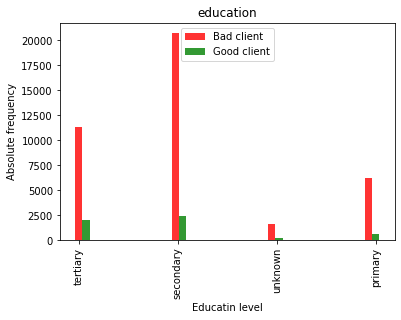

In [29]:
# Graph 'education' vs. 'target'
education_0 = data[data.target == 0].iloc[:,3:4]
education_1 = data[data.target == 1].iloc[:,3:4]

a = np.array(education_0)
b = np.array(education_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.8, label='Bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 0.8, label='Good client', align="right")
plt.legend(loc='upper center')
plt.title('education', fontsize=12)
plt.xlabel('Educatin level')
plt.xticks(rotation='vertical')
plt.ylabel('Absolute frequency')
plt.show()


## - default

Variable: 'default'
Discription: has credit in default?
Type of variable: object
Total observations: 45211
Unique values: 2
List of unique values: ['no' 'yes']



,Freq abs,percent %
no,44396,98.2
yes,815,1.8


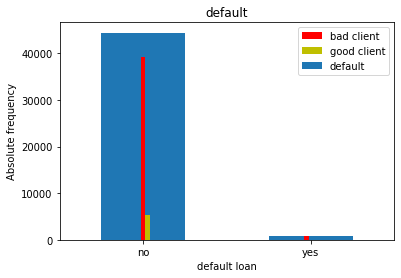

In [30]:
print("Variable: 'default'")
print("Discription: has credit in default?")
print(f"Type of variable: {data.default.dtype}")
print(f"Total observations: {data.default.shape[0]}")
print(f"Unique values: {data.default.nunique()}")
print(f"List of unique values: {data.default.unique()}")
print("")

# Graph "bar"
data['default'].value_counts(dropna=False).plot(kind='bar', figsize=(6,4));

# Number of observations by class
default_obs = data.default.value_counts()
default_o = pd.DataFrame(default_obs)
default_o.rename(columns={"default":"Freq abs"}, inplace=True)
default_o_pc = (data.default.value_counts(normalize=True) * 100).round(decimals=2)
default_obs_pc = pd.DataFrame(default_o_pc)
default_obs_pc.rename(columns={"default":"percent %"}, inplace=True)
default_obs = pd.concat([default_o,default_obs_pc], axis=1)
display(default_obs)
# Graph 'default' vs. 'target'
default_0 = data[data.target == 0].iloc[:,4:5]
default_1 = data[data.target == 1].iloc[:,4:5]

a = np.array(default_0)
b = np.array(default_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 1, label='bad client', align="left")
plt.hist(b, bins=40, color="y", alpha = 1, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('default', fontsize=12)
plt.xlabel('default loan')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

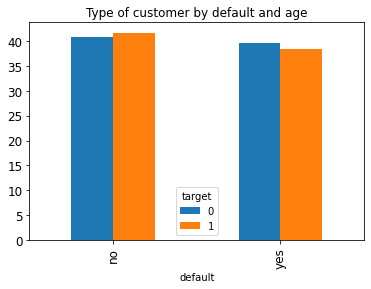

In [31]:
# Graph: Type of customer by default and age
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="default",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["default"], 
                       ascending=True).plot(kind="bar",
                                             title=("Type of customer by default and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

## - housing

Variable: 'housing'
Discription: has housing loan?
Type of variable: object
Total observations: 45211
Unique values: 2
List of unique values: ['yes' 'no']



,Freq abs,percent %
yes,25130,55.58
no,20081,44.42


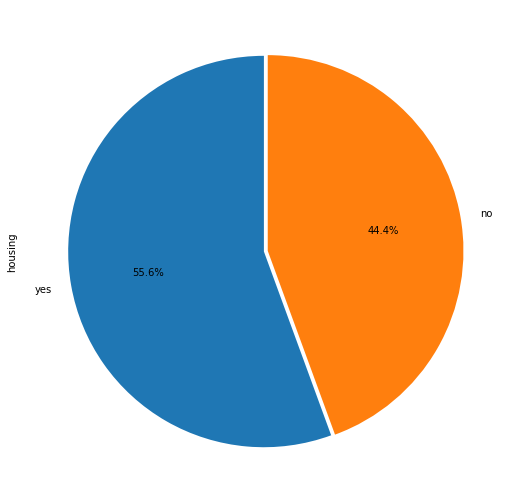

In [32]:
print("Variable: 'housing'")
print("Discription: has housing loan?")
print(f"Type of variable: {data.housing.dtype}")
print(f"Total observations: {data.housing.shape[0]}")
print(f"Unique values: {data.housing.nunique()}")
print(f"List of unique values: {data.housing.unique()}")
print("")

# Graph "pie"
data['housing'].value_counts(dropna=False).plot(kind='pie', 
                                              explode = (0.01, 0.01), 
                                              figsize=(13,9), 
                                              autopct='%1.1f%%',
                                              startangle=90);

# Number of observations by class
hous_obs = data.housing.value_counts()
hous_o = pd.DataFrame(hous_obs)
hous_o.rename(columns={"housing":"Freq abs"}, inplace=True)
hous_o_pc = (data.housing.value_counts(normalize=True) * 100).round(decimals=2)
hous_obs_pc = pd.DataFrame(hous_o_pc)
hous_obs_pc.rename(columns={"housing":"percent %"}, inplace=True)
hous_obs = pd.concat([hous_o,hous_obs_pc], axis=1)
display(hous_obs)

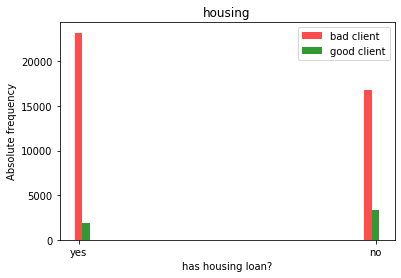

In [33]:
# Graph 'housing' vs. 'target'
housing_0 = data[data.target == 0].iloc[:,6:7]
housing_1 = data[data.target == 1].iloc[:,6:7]

a = np.array(housing_0)
b = np.array(housing_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.7, label='bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 0.8, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('housing', fontsize=12)
plt.xlabel('has housing loan?')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

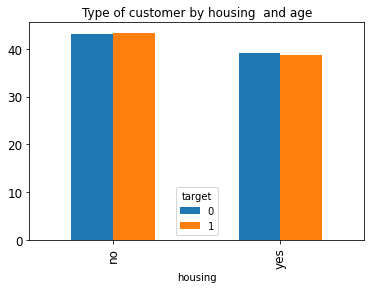

In [34]:
# Graph: Type of customer by housing and age
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="housing",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["housing"], 
                       ascending=True).plot(kind="bar",
                                             title=("Type of customer by housing  and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

## - loan

Variable: 'loan'
Discription: has personal loan?
Type of variable: object
Total observations: 45211
Unique values: 2
List of unique values: ['no' 'yes']



,Freq abs,percent %
no,37967,83.98
yes,7244,16.02


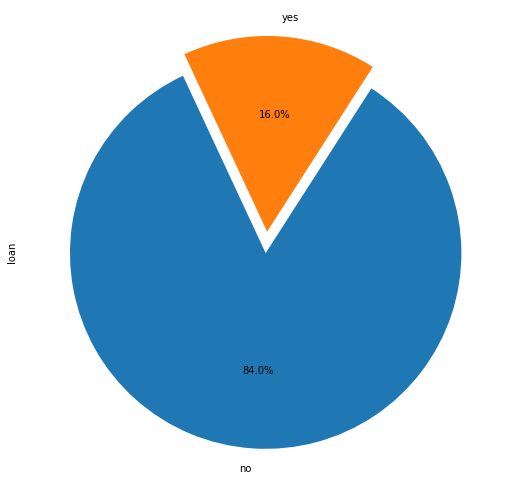

In [35]:
print("Variable: 'loan'")
print("Discription: has personal loan?")
print(f"Type of variable: {data.loan.dtype}")
print(f"Total observations: {data.loan.shape[0]}")
print(f"Unique values: {data.loan.nunique()}")
print(f"List of unique values: {data.loan.unique()}")
print("")

# Graph "pie"
data['loan'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(13,9), 
                                                explode = (0.01, 0.1),
                                                autopct='%1.1f%%',
                                                startangle=115);

# Number of observations by class
loan_obs = data.loan.value_counts()
loan_o = pd.DataFrame(loan_obs)
loan_o.rename(columns={"loan":"Freq abs"}, inplace=True)
loan_o_pc = (data.loan.value_counts(normalize=True) * 100).round(decimals=2)
loan_obs_pc = pd.DataFrame(loan_o_pc)
loan_obs_pc.rename(columns={"loan":"percent %"}, inplace=True)
loan_obs = pd.concat([loan_o,loan_obs_pc], axis=1)
display(loan_obs)

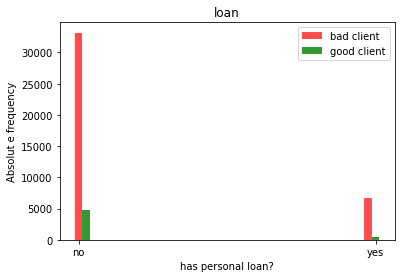

In [36]:
# Graph 'loan' vs. 'target'
loan_0 = data[data.target == 0].iloc[:,7:8]
loan_1 = data[data.target == 1].iloc[:,7:8]

a = np.array(loan_0)
b = np.array(loan_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.7, label='bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 0.8, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('loan', fontsize=12)
plt.xlabel('has personal loan?')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolut e frequency')
plt.show()

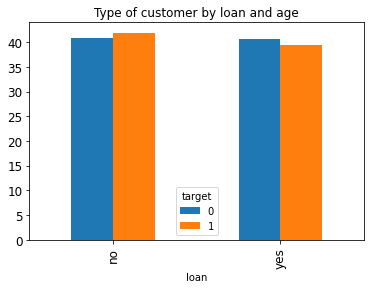

In [37]:
# Graph: Type of customer by loan and age
# Pivot_table
type_pivot =data.pivot_table(
    columns="target",
    index="loan",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["loan"], 
                       ascending=True).plot(kind="bar",
                                             title=("Type of customer by loan and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

## - poutcome

Variable: 'poutcome'
Discription: outcome of the previous marketing campaign
Type of variable: object
Total observations: 45211
Unique values: 4
List of unique values: ['unknown' 'failure' 'other' 'success']



,Freq abs,percent %
unknown,36959,81.75
failure,4901,10.84
other,1840,4.07
success,1511,3.34


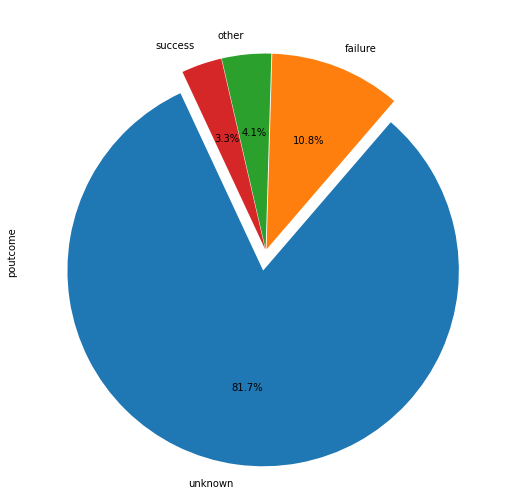

In [38]:
print("Variable: 'poutcome'")
print("Discription: outcome of the previous marketing campaign")
print(f"Type of variable: {data.poutcome.dtype}")
print(f"Total observations: {data.poutcome.shape[0]}")
print(f"Unique values: {data.poutcome.nunique()}")
print(f"List of unique values: {data.poutcome.unique()}")
print("")

# Graph "pie"
data['poutcome'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(13,9), 
                                                explode = (0.1, 0.01, 0.01, 0.01),
                                                autopct='%1.1f%%',
                                                startangle=115);

# Number of observations by class
pout_obs = data.poutcome.value_counts()
pout_o = pd.DataFrame(pout_obs)
pout_o.rename(columns={"poutcome":"Freq abs"}, inplace=True)
pout_o_pc = (data.poutcome.value_counts(normalize=True) * 100).round(decimals=2)
pout_obs_pc = pd.DataFrame(pout_o_pc)
pout_obs_pc.rename(columns={"poutcome":"percent %"}, inplace=True)
pout_obs = pd.concat([pout_o,pout_obs_pc], axis=1)
pout_obs

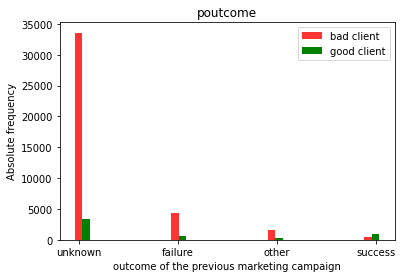

In [39]:
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="poutcome",
    values="age", aggfunc=np.mean)

# Graph 'default' vs. 'target'
pout_0 = data[data.target == 0].iloc[:,15:16]
pout_1 = data[data.target == 1].iloc[:,15:16]

a = np.array(pout_0)
b = np.array(pout_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.8, label='bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 1, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('poutcome', fontsize=12)
plt.xlabel('outcome of the previous marketing campaign')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

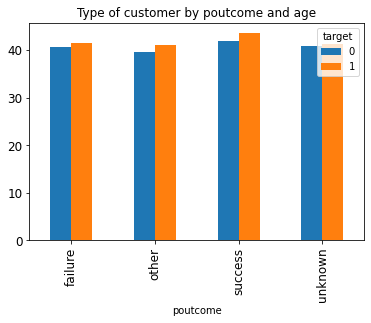

In [40]:
# Graph: Type of customer by poutcome and age
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="poutcome",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["poutcome"], 
                       ascending=True).plot(kind="bar",
                                             title=("Type of customer by poutcome and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

## - Contact

Designation,Value
Variable,contact
Description,contact communication type
Type of variable,object
Total observations,45211
Unique values,3


List of unique values: ['unknown' 'cellular' 'telephone']


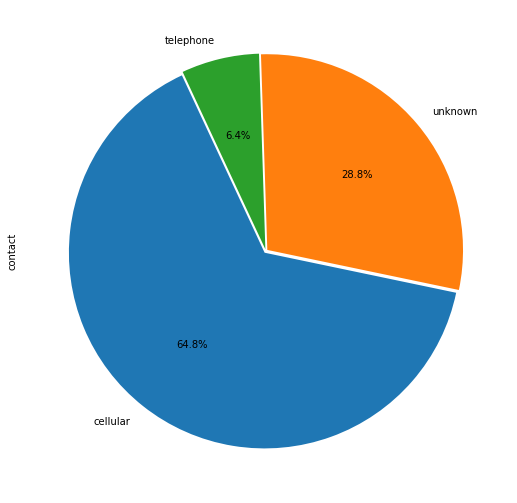

In [41]:
# General stats description
stats_contact = {'Designation': ['Value'],
            'Variable': 'contact',
            'Description': 'contact communication type',
            'Type of variable': data.contact.dtype,
            'Total observations': data.contact.shape[0],
            'Unique values': data.contact.nunique(),
           }

st_contact = pd.DataFrame(stats_contact, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Total observations',
                                     'Unique values',
                                        ])
st_contact.set_index("Designation", inplace=True)

results = st_contact.T
resultsT = st_contact
display(results)
print(f"List of unique values: {data.contact.unique()}")

# Graph "pie"
data['contact'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(13,9), 
                                                explode = (0.01, 0.01, 0.01),
                                                autopct='%1.1f%%',
                                                startangle=115);


In [42]:
# Number of observations by class
contact_obs = data.contact.value_counts()
contact_o = pd.DataFrame(contact_obs)
contact_o.rename(columns={"contact":"Freq abs"}, inplace=True)
contact_o_pc = (data.contact.value_counts(normalize=True) * 100).round(decimals=2)
contact_obs_pc = pd.DataFrame(contact_o_pc)
contact_obs_pc.rename(columns={"contact":"percent %"}, inplace=True)
contact_obs = pd.concat([contact_o,contact_obs_pc], axis=1)
contact_obs

,Freq abs,percent %
cellular,29285,64.77
unknown,13020,28.80
telephone,2906,6.43


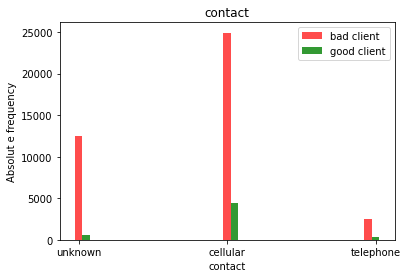

In [43]:
# Graph 'loan' vs. 'target'
contact_0 = data[data.target == 0].iloc[:,8:9]
contact_1 = data[data.target == 1].iloc[:,8:9]

a = np.array(contact_0)
b = np.array(contact_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.7, label='bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 0.8, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('contact', fontsize=12)
plt.xlabel('contact')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolut e frequency')
plt.show()

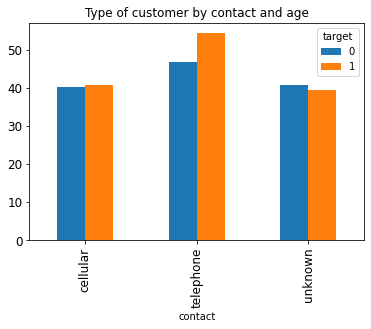

In [44]:
# Graph: Type of customer by contact and age
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="contact",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["contact"], 
                       ascending=True).plot(kind="bar",
                                             title=("Type of customer by contact and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

## - Month

Designation,Value
Variable,month
Description,last contact most of year
Type of variable,object
Total observations,45211
Unique values,12


List of unique values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


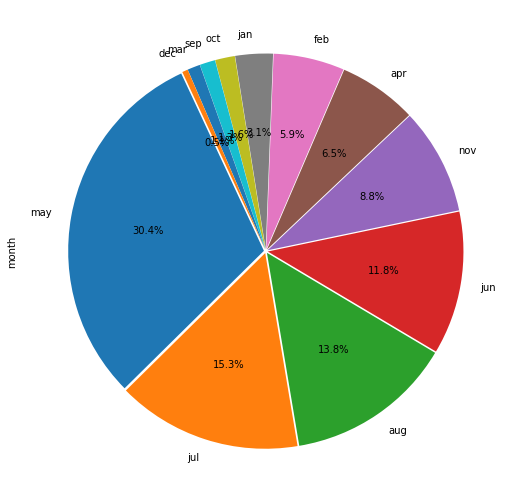

In [45]:
# General stats description
stats_month = {'Designation': ['Value'],
            'Variable': 'month',
            'Description': 'last contact most of year',
            'Type of variable': data.month.dtype,
            'Total observations': data.month.shape[0],
            'Unique values': data.month.nunique(),
           }

st_month = pd.DataFrame(stats_month, columns = ['Designation', 
                                     'Variable',
                                     'Description',
                                     'Type of variable',
                                     'Total observations',
                                     'Unique values',
                                        ])
st_month.set_index("Designation", inplace=True)

results = st_month.T
resultsT = st_month
display(results)
print(f"List of unique values: {data.month.unique()}")



# Graph "pie"
data['month'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(13,9), 
                                                explode = (0.01, 0.01, 0.01,0.01, 0.01, 0.01,0.01, 0.01, 0.01,0.01, 0.01, 0.01),
                                                autopct='%1.1f%%',
                                                startangle=115);

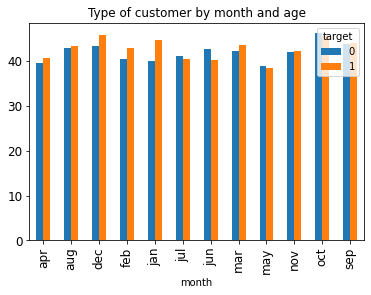

In [46]:
# Graph: Type of customer by month and age
# Pivot_table
type_pivot = data.pivot_table(
    columns="target",
    index="month",
    values="age", aggfunc=np.mean)

# Display pivot_table
type_pivot.sort_values(by=["month"], 
                       ascending=True).plot(kind="bar",
                                             title=("Type of customer by month and age"), 
                                             figsize=(6,4),
                                             fontsize = 12);

In [47]:
# Number of observations by class
month_obs = data.month.value_counts()
month_o = pd.DataFrame(month_obs)
month_o.rename(columns={"month":"Freq abs"}, inplace=True)
month_o_pc = (data.month.value_counts(normalize=True) * 100).round(decimals=2)
month_obs_pc = pd.DataFrame(month_o_pc)
month_obs_pc.rename(columns={"month":"percent %"}, inplace=True)
month_obs = pd.concat([month_o,month_obs_pc], axis=1)
month_obs



,Freq abs,percent %
may,13766,30.45
jul,6895,15.25
aug,6247,13.82
jun,5341,11.81
nov,3970,8.78
apr,2932,6.49
feb,2649,5.86
jan,1403,3.10
oct,738,1.63
sep,579,1.28


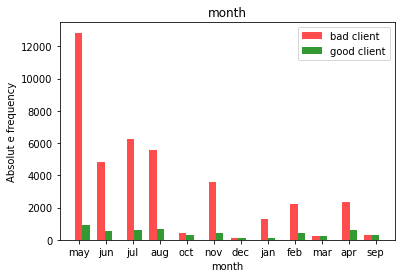

In [48]:
# Graph 'loan' vs. 'target'
month_0 = data[data.target == 0].iloc[:,10:11]
month_1 = data[data.target == 1].iloc[:,10:11]

a = np.array(month_0)
b = np.array(month_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 0.7, label='bad client', align="left")
plt.hist(b, bins=40, color="g", alpha = 0.8, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('month', fontsize=12)
plt.xlabel('month')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolut e frequency')
plt.show()

## determine the most common classes per category

In [49]:
# Create list of features
cat_features = list(data.select_dtypes('object').columns)
int_features = list(data.select_dtypes('int64').columns)
float_features = list(data.select_dtypes('float64').columns)
num_features = int_features+float_features

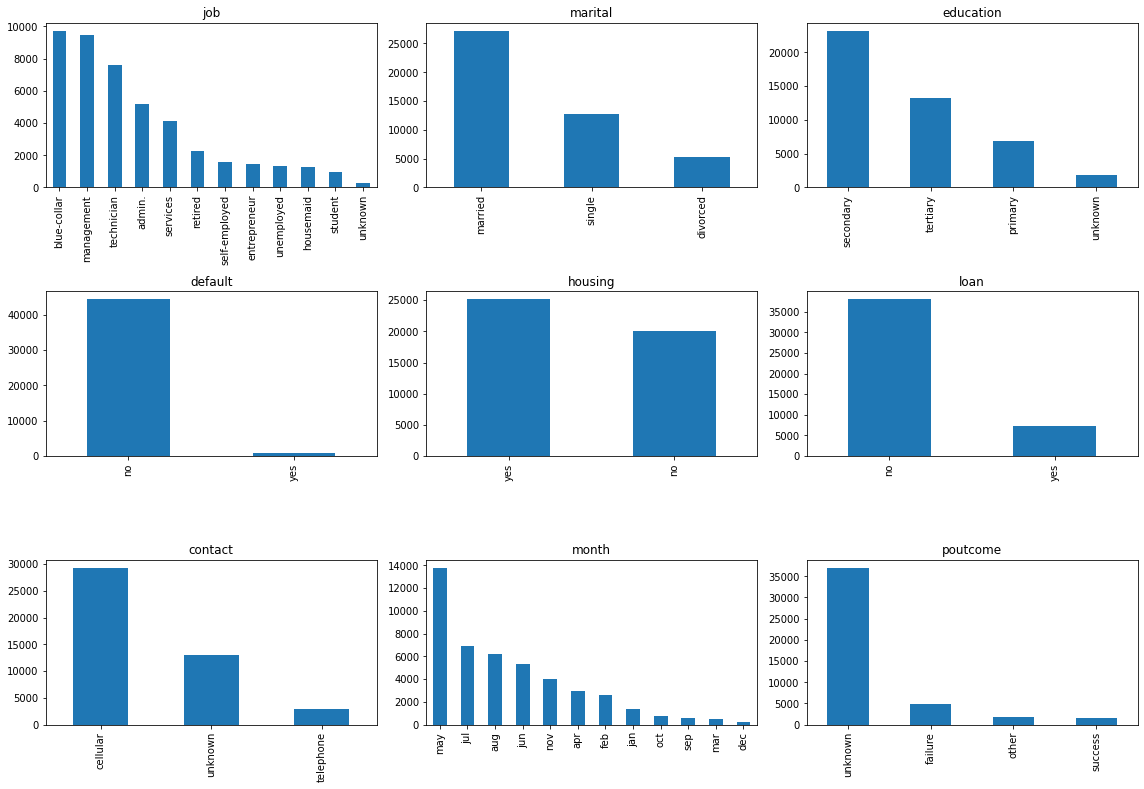

In [50]:
n = len(cat_features)
i=1
plt.figure(figsize=(16,14))

for feature in data[cat_features]:
    plt.subplot(round(n/2),round(n/3), i)
    data[feature].value_counts().plot.bar()
    plt.xticks(rotation=90)
    plt.title(feature)
    i+=1
plt.savefig('cat_com.png')
plt.tight_layout();

## Subscription frequency per category 

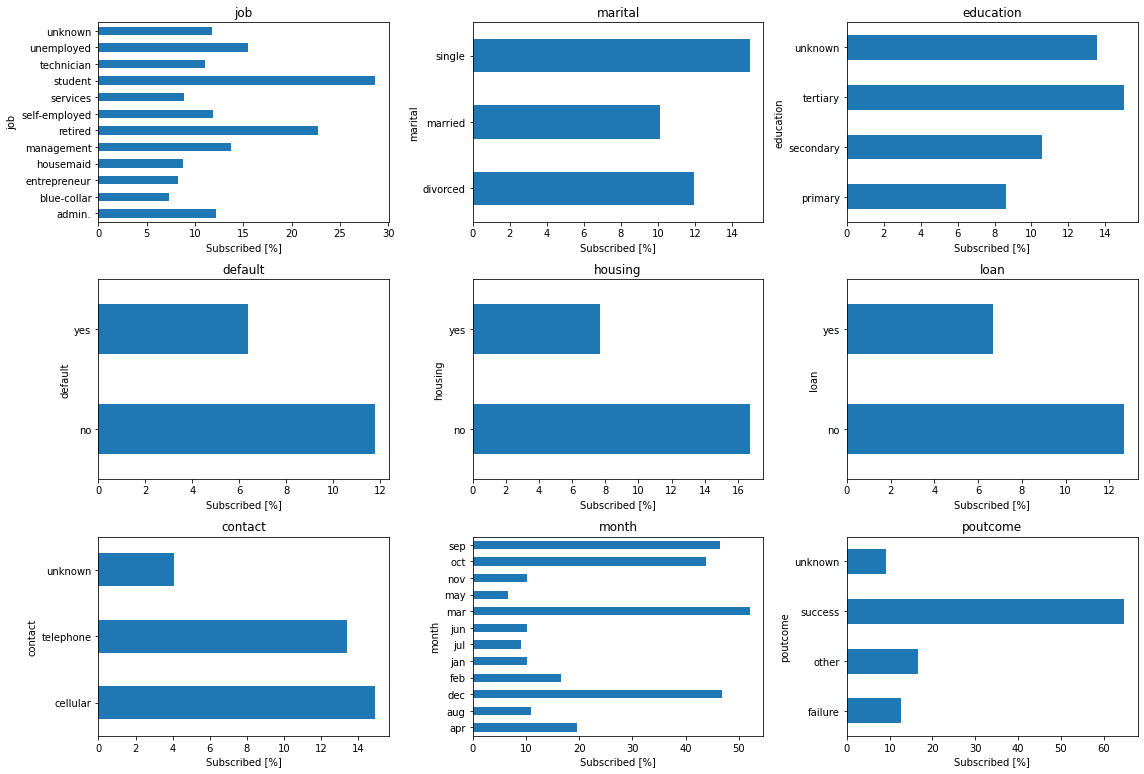

In [51]:
n = len(cat_features)
i=1
plt.figure(figsize=(16,14))

for feature in data[cat_features]:
    plt.subplot(round(n/2),round(n/3), i)
    data.groupby([feature])['target'].mean().multiply(100).plot.barh()
    plt.xlabel('Subscribed [%]')
    plt.title(feature)
    i+=1

plt.tight_layout()
plt.show()

In [52]:
for col in cat_features:
    display(pd.DataFrame(data[col].value_counts()))

,job
blue-collar,9732
management,9458
technician,7597
admin.,5171
services,4154
retired,2264
self-employed,1579
entrepreneur,1487
unemployed,1303
housemaid,1240


,marital
married,27214
single,12790
divorced,5207


,education
secondary,23202
tertiary,13301
primary,6851
unknown,1857


,default
no,44396
yes,815


,housing
yes,25130
no,20081


,loan
no,37967
yes,7244


,contact
cellular,29285
unknown,13020
telephone,2906


,month
may,13766
jul,6895
aug,6247
jun,5341
nov,3970
apr,2932
feb,2649
jan,1403
oct,738
sep,579


,poutcome
unknown,36959
failure,4901
other,1840
success,1511


## Setting-up numeric and categoric dataframes

In [53]:
# Numeric dataframe
data_num = data.copy()
data_num = data.select_dtypes(include=["float64","int64"])

In [54]:
# Categoric dataframe
data_cat = data.copy()
data_cat = data.select_dtypes(exclude=["float64","int64"])

## Correlations between numeric variables

In [55]:
# Subdivision of target
ynum = data_num.target
Xnum = data_num.drop(["target"], axis= "columns")

In [56]:
# Identifying variables with predictive power (Pearson Correlation p-value)
pd.DataFrame(
    [scipy.stats.pearsonr(Xnum[col], ynum) for col in Xnum.columns],
    columns=["Pearson Corr.", "p-value"],
    index=Xnum.columns,
).round(2)

,Pearson Corr.,p-value
age,0.03,0.0
balance,0.05,0.0
day,-0.03,0.0
duration,0.39,0.0
campaign,-0.07,0.0
pdays,0.10,0.0
previous,0.09,0.0


All variables have predictive power

Strategy: No transformation.

In [57]:
# Numeric variables with higher monotonicity (spearman)
data_spearman = data_num.copy()
data_spearman.drop(["target"], axis=1, inplace=True)

The numeric 10 most correlated pairs, Spearman method:


,X,Y,r
0,pdays,previous,0.985645
1,day,campaign,0.139581
2,age,balance,0.096380
3,balance,previous,0.079536
4,balance,pdays,0.069676
5,day,previous,-0.087780
6,day,pdays,-0.092226
7,duration,campaign,-0.107962
8,campaign,previous,-0.108448
9,campaign,pdays,-0.112284


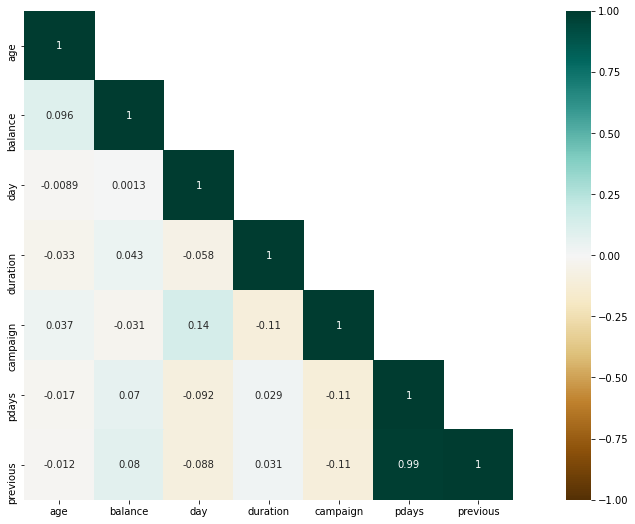

In [58]:
print("The numeric 10 most correlated pairs, Spearman method:")
spearman_rank = pg.pairwise_corr(data_spearman, method='spearman').loc[:,['X','Y','r']]
pos = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[:5,:]
neg = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[-5:,:]
con = pd.concat([pos,neg], axis=0)
display(con.reset_index(drop=True))

mask = np.triu(data_spearman.corr(method='spearman'), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(data_spearman.corr(method='spearman'), annot=True, 
            vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);

In [59]:
# The numeric most correlated with the target (Pearson)
pearson = data_num.corr()
corr_target = pearson.target
display(corr_target.sort_values(ascending=False))
print("")
print("Ordered by rank in absolute values")
display(corr_target.abs().sort_values(ascending=False))

target      1.000000
duration    0.394521
pdays       0.103621
previous    0.093236
balance     0.052838
age         0.025155
day        -0.028348
campaign   -0.073172
Name: target, dtype: float64


Ordered by rank in absolute values


target      1.000000
duration    0.394521
pdays       0.103621
previous    0.093236
campaign    0.073172
balance     0.052838
day         0.028348
age         0.025155
Name: target, dtype: float64

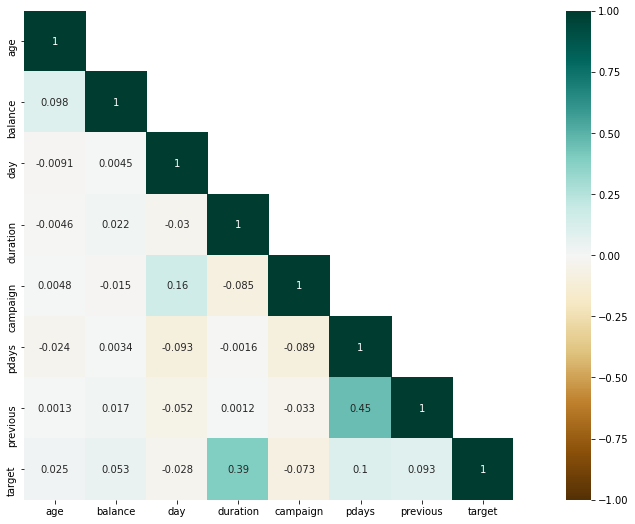

In [60]:
# Heatmap visualization: Pearson
mask = np.triu(data_num.corr(method="pearson"), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(data_num.corr(method="pearson"), annot=True, 
            vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);

## Correlation between categoric variables 

In [61]:
# Creating categoric subset in order to see correlations results
Xcat = data_cat.select_dtypes(exclude=['int64','float64']).copy()
ycat = data.target

In [62]:
# Statistic values and meaning results for each categoric variable
for col in Xcat.columns:
    table = pd.crosstab(Xcat[col], ycat)
    print()
    display(table)
    _, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    print(f"p-value: {pval:.3f}")

target,0,1
job,,
admin.,4540,631
blue-collar,9024,708
entrepreneur,1364,123
housemaid,1131,109
management,8157,1301
retired,1748,516
self-employed,1392,187
services,3785,369
student,669,269


p-value: 0.000



target,0,1
marital,,
divorced,4585,622
married,24459,2755
single,10878,1912


p-value: 0.000



target,0,1
education,,
primary,6260,591
secondary,20752,2450
tertiary,11305,1996
unknown,1605,252


p-value: 0.000



target,0,1
default,,
no,39159,5237
yes,763,52


p-value: 0.000



target,0,1
housing,,
no,16727,3354
yes,23195,1935


p-value: 0.000



target,0,1
loan,,
no,33162,4805
yes,6760,484


p-value: 0.000



target,0,1
contact,,
cellular,24916,4369
telephone,2516,390
unknown,12490,530


p-value: 0.000



target,0,1
month,,
apr,2355,577
aug,5559,688
dec,114,100
feb,2208,441
jan,1261,142
jul,6268,627
jun,4795,546
mar,229,248
may,12841,925


p-value: 0.000



target,0,1
poutcome,,
failure,4283,618
other,1533,307
success,533,978
unknown,33573,3386


p-value: 0.000



target,0,1
age_bins,,
Young,5880,1138
Adult,33351,3642
Senior,686,502


p-value: 0.000


## Removing Outliers and Missing Values for numeric variables

In [63]:
# Removing Target and making a copy
data_drop = data_num.drop(["target"], axis=1).copy()

,age,balance,day,duration,campaign,pdays,previous
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441


Any missing values: False



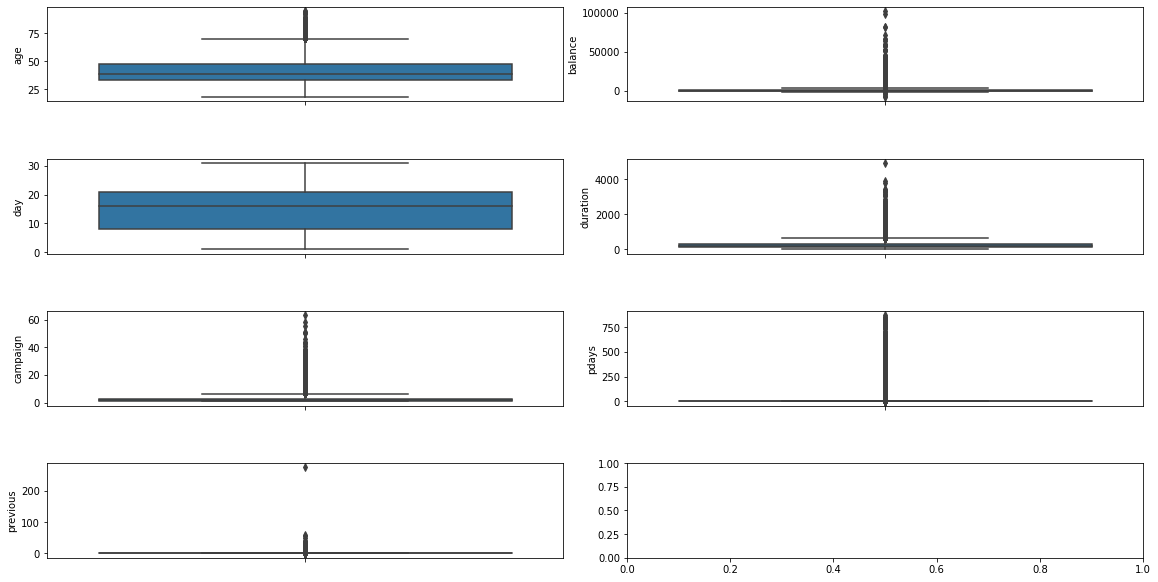

In [64]:
# Visualization of numerical data dispersion (Boxplot)
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16, 8))
index = 0
axs = axs.flatten()
for k,v in data_drop.items():
    sns.boxplot(y=k, data=data_drop, ax=axs[index], orient="h")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

display(data_drop.describe().loc[["mean","50%","std"]])
print(f"Any missing values: {data_drop.isnull().values.any()}")
print("")

In [65]:
for column in data_drop.columns:
    median = data_drop[column].quantile()
    iqr_1_5 = (data_drop[column].quantile(q = 0.75) - data_drop[column].quantile(q = 0.25)) * 1.5
    outliers = data_drop[(data_drop[column]< median - iqr_1_5) | (data_drop[column] > median + iqr_1_5)][column].count()
    outliers_pct = round(outliers / data_drop[column].count() * 100, 1)
    print("'{}' = {} ({}%) outliers".format(column, outliers, outliers_pct))

'age' = 1041 (2.3%) outliers
'balance' = 6963 (15.4%) outliers
'day' = 0 (0.0%) outliers
'duration' = 5283 (11.7%) outliers
'campaign' = 4355 (9.6%) outliers
'pdays' = 8257 (18.3%) outliers
'previous' = 8257 (18.3%) outliers


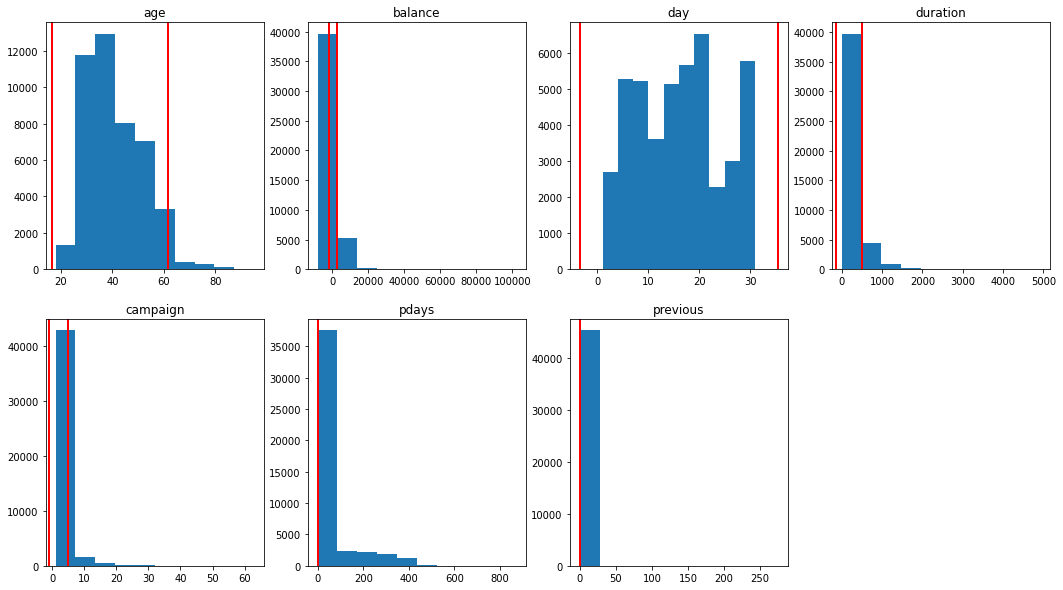

In [66]:
fig, ax  = plt.subplots(figsize = (18,10))
ax.axis("off")
v = 1
for column in data_drop.columns:
    ax1 = fig.add_subplot(2,4,v)
    plt.hist(data_drop[column])
    ax1.set_title(column)
    v+=1
    median = data_drop[column].quantile()
    iqr_1_5 = (data_drop[column].quantile(q = 0.75) - data_drop[column].quantile(q = 0.25)) * 1.5
    outliers = data_drop[(data_drop[column]< median - iqr_1_5) | (data_drop[column] > median + iqr_1_5)][column].count()
    ax1.axvline(median - iqr_1_5, color='red', linewidth=2)  
    ax1.axvline(median + iqr_1_5, color='red', linewidth=2)  

plt.show()

## Removing Outliers and Missing Values for categoric variables

In [67]:
# Creating a copy
data_cat_t = data_cat.copy()
data_cat.describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,age_bins
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45199
unique,12,3,4,2,2,2,3,12,4,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,Adult
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,36993


### Variable: job

In [68]:
print(f"Unique values: {data_cat.job.nunique()}")
print("")

# Observations by class
num_obs = data_cat.job.value_counts()
num_o = pd.DataFrame(num_obs)
num_o.rename(columns={"job":"Freq abs"}, inplace=True)
num_o_pc = (data_cat.job.value_counts(normalize=True) * 100).round(decimals=2)
num_obs_pc = pd.DataFrame(num_o_pc)
num_obs_pc.rename(columns={"job":"percent %"}, inplace=True)
n_obs = pd.concat([num_o,num_obs_pc], axis=1)
display(n_obs)

Unique values: 12



,Freq abs,percent %
blue-collar,9732,21.53
management,9458,20.92
technician,7597,16.80
admin.,5171,11.44
services,4154,9.19
retired,2264,5.01
self-employed,1579,3.49
entrepreneur,1487,3.29
unemployed,1303,2.88
housemaid,1240,2.74


In this case, 'unknown' are interpreted as missing values.

Strategy: Replacing by the most frequent value.

Unique values: 11


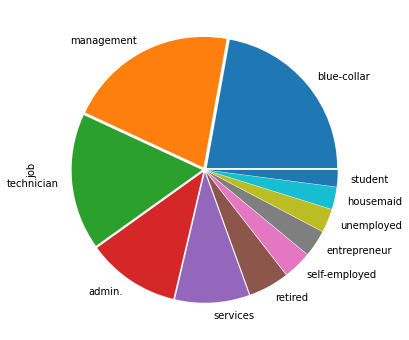

In [69]:
# Replacing 'unknown' by NaN
data_cat_t.job.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation missing values by the modal value
data_cat_t['job'] = data_cat_t.job.fillna(data_cat_t.job.value_counts().index[0])

# Confirming and visualizing of "job"
data_cat_t.job.value_counts(dropna=False).plot(kind='pie', figsize=(10,6), 
                                           explode=(0.02, 0.02, 0.02, 0.02, 
                                                    0.02, 0.02, 0.02, 0.02,
                                                    0.02, 0.02, 0.02));
print(f"Unique values: {data_cat_t.job.nunique()}")

Encoded by dummies method and numeric tranformation

In [70]:
# Encoding 'job' OHE
data_job = data_cat_t.job
job_ohe = pd.get_dummies(data_job)
binary_encoder_job = BinaryEncoder()
job_bin = binary_encoder_job.fit_transform(data_job)
print(f'''
*Results*
job OHE: {job_ohe.shape[1]} columns''')


*Results*
job OHE: 11 columns


In [71]:
# Removing 'job' and concatenation job_ohe
data_cat_t.drop(["job"],axis=1,inplace=True)
data_cat_t = pd.concat([data_cat_t,job_ohe],axis=1)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,marital,education,default,housing,loan,contact,month,poutcome,age_bins,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,married,tertiary,no,yes,no,unknown,may,unknown,Adult,0,0,0,0,1,0,0,0,0,0,0
1,single,secondary,no,yes,no,unknown,may,unknown,Adult,0,0,0,0,0,0,0,0,0,1,0


(45211, 20)

## Variable: marital

In [72]:
print(f"Unique values: {data_cat.marital.nunique()}")
print("")

# Observations by class
marital_obs = data_cat.marital.value_counts()
marital_o = pd.DataFrame(marital_obs)
marital_o.rename(columns={"marital":"Freq abs"}, inplace=True)
marital_o_pc = (data_cat.marital.value_counts(normalize=True) * 100).round(decimals=2)
marital_obs_pc = pd.DataFrame(marital_o_pc)
marital_obs_pc.rename(columns={"marital":"percent %"}, inplace=True)
marital_obs = pd.concat([marital_o,marital_obs_pc], axis=1)
display(marital_obs)

Unique values: 3



,Freq abs,percent %
married,27214,60.19
single,12790,28.29
divorced,5207,11.52


In this case, 'unknown' are interpreted as missing values.

Strategy: Replacing by the most frequent value.

Unique values: 3



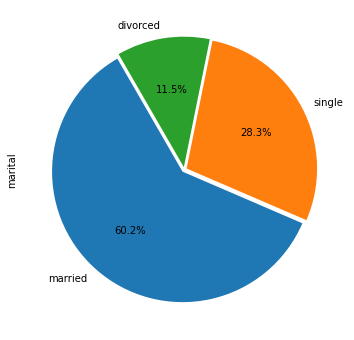

In [73]:
# Replacing 'unknown' by NaN
data_cat_t.marital.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation of missing values by modal value
data_cat_t['marital'] = data_cat_t.marital.fillna(data_cat_t.marital.value_counts().index[0])

# Graph "pie"
data_cat_t['marital'].value_counts(dropna=False).plot(kind='pie', figsize=(10,6),
                                              explode = (0.02, 0.02, 0.02),
                                              autopct='%1.1f%%',
                                              startangle=120);
print(f"Unique values: {data_cat_t.marital.nunique()}")
print("")

Encoded by dummies method and numeric tranformation

In [74]:
# marital
data_marital = data_cat_t.marital
marital_ohe = pd.get_dummies(data_marital)
binary_encoder_marital = BinaryEncoder()
marital_bin = binary_encoder_marital.fit_transform(data_marital)
print(f'''
*Results*
marital OHE: {marital_ohe.shape[1]} columns''')


*Results*
marital OHE: 3 columns


In [75]:
data_cat_t.drop(["marital"],axis=1,inplace=True)
data_cat_t = pd.concat([data_cat_t,marital_ohe],axis=1)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,default,housing,loan,contact,month,poutcome,age_bins,admin.,blue-collar,...,management,retired,self-employed,services,student,technician,unemployed,divorced,married,single
0,tertiary,no,yes,no,unknown,may,unknown,Adult,0,0,...,1,0,0,0,0,0,0,0,1,0
1,secondary,no,yes,no,unknown,may,unknown,Adult,0,0,...,0,0,0,0,0,1,0,0,0,1


(45211, 22)

## Variable: education

In [76]:
print(f"Unique values: {data_cat.education.nunique()}")
print("")

# Observations by class
edu_obs = data_cat.education.value_counts()
edu_o = pd.DataFrame(edu_obs)
edu_o.rename(columns={"education":"Freq abs"}, inplace=True)
edu_o_pc = (data_cat.education.value_counts(normalize=True) * 100).round(decimals=2)
edu_obs_pc = pd.DataFrame(edu_o_pc)
edu_obs_pc.rename(columns={"education":"percent %"}, inplace=True)
edu_obs = pd.concat([edu_o,edu_obs_pc], axis=1)
display(edu_obs)

Unique values: 4



,Freq abs,percent %
secondary,23202,51.32
tertiary,13301,29.42
primary,6851,15.15
unknown,1857,4.11


In this case, 'unknown' are interpreted as missing values.

Strategy: Replacing by the most frequent value.

Unique values: 3



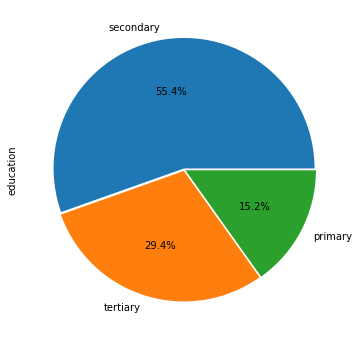

In [77]:
# Replacing 'unknown' by NaN
data_cat_t.education.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation of missing values by modal value
data_cat_t['education'] = data_cat_t.education.fillna(data_cat_t.education.value_counts().index[0])

# Graph "pie"
data_cat_t['education'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(10,6), 
                                                explode = (0.01, 0.01, 0.01),
                                                autopct='%1.1f%%',
                                                startangle=0);
print(f"Unique values: {data_cat_t.education.nunique()}")
print("")

In [78]:
data_cat_t.education.value_counts()

secondary    25059
tertiary     13301
primary       6851
Name: education, dtype: int64

In [79]:
data_cat_t["education"] = data_cat_t.education.map({
                                                "secondary":3, "tertiary":2,
                                                "primary":1 })
display(data_cat_t.education.value_counts())
display(data_cat_t.head(2))
display(data_cat_t.shape)

3    25059
2    13301
1     6851
Name: education, dtype: int64

,education,default,housing,loan,contact,month,poutcome,age_bins,admin.,blue-collar,...,management,retired,self-employed,services,student,technician,unemployed,divorced,married,single
0,2,no,yes,no,unknown,may,unknown,Adult,0,0,...,1,0,0,0,0,0,0,0,1,0
1,3,no,yes,no,unknown,may,unknown,Adult,0,0,...,0,0,0,0,0,1,0,0,0,1


(45211, 22)

## Variable: default

Unique values: 2



,Freq abs,percent %
no,44396,98.2
yes,815,1.8


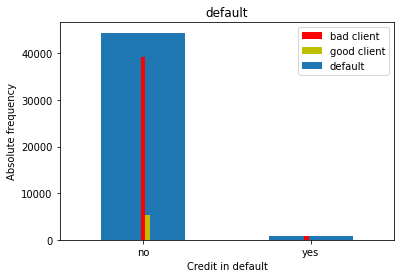

In [80]:
print(f"Unique values: {data.default.nunique()}")
print("")

# Visualizing graph "bar"
data['default'].value_counts(dropna=False).plot(kind='bar', figsize=(6,4));

# Number of observations by class
default_obs = data.default.value_counts()
default_o = pd.DataFrame(default_obs)
default_o.rename(columns={"default":"Freq abs"}, inplace=True)
default_o_pc = (data.default.value_counts(normalize=True) * 100).round(decimals=2)
default_obs_pc = pd.DataFrame(default_o_pc)
default_obs_pc.rename(columns={"default":"percent %"}, inplace=True)
default_obs = pd.concat([default_o,default_obs_pc], axis=1)
display(default_obs)


# Graph 'default' vs. 'target'
default_0 = data[data.target == 0].iloc[:,4:5]
default_1 = data[data.target == 1].iloc[:,4:5]

a = np.array(default_0)
b = np.array(default_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 1, label='bad client', align="left")
plt.hist(b, bins=40, color="y", alpha = 1, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('default', fontsize=12)
plt.xlabel('Credit in default')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

In this case, 'unknown' are interpreted as missing values. The 'yes' class is meaningless and any imputation to the missing values would deeply compromise its meaning.

Strategy: Remove variable.

In [81]:
data_cat_t.drop(["default"], axis=1, inplace=True)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,housing,loan,contact,month,poutcome,age_bins,admin.,blue-collar,entrepreneur,...,management,retired,self-employed,services,student,technician,unemployed,divorced,married,single
0,2,yes,no,unknown,may,unknown,Adult,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,3,yes,no,unknown,may,unknown,Adult,0,0,0,...,0,0,0,0,0,1,0,0,0,1


(45211, 21)

## Variable: housing

Unique values: 2



,Freq abs,percent %
yes,25130,55.58
no,20081,44.42


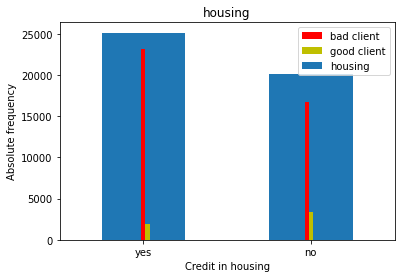

In [82]:
print(f"Unique values: {data_cat.housing.nunique()}")
print("")

# Visualizing graph "bar"
data['housing'].value_counts(dropna=False).plot(kind='bar', figsize=(6,4));
# Observations by class
hous_obs = data_cat.housing.value_counts()
hous_o = pd.DataFrame(hous_obs)
hous_o.rename(columns={"housing":"Freq abs"}, inplace=True)
hous_o_pc = (data_cat.housing.value_counts(normalize=True) * 100).round(decimals=2)
hous_obs_pc = pd.DataFrame(hous_o_pc)
hous_obs_pc.rename(columns={"housing":"percent %"}, inplace=True)
hous_obs = pd.concat([hous_o,hous_obs_pc], axis=1)
display(hous_obs)
# Graph 'housing' vs. 'target'
housing_0 = data[data.target == 0].iloc[:,6:7]
housing_1 = data[data.target == 1].iloc[:,6:7]

a = np.array(housing_0)
b = np.array(housing_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 1, label='bad client', align="left")
plt.hist(b, bins=40, color="y", alpha = 1, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('housing', fontsize=12)
plt.xlabel('Credit in housing')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

Unique values: 2



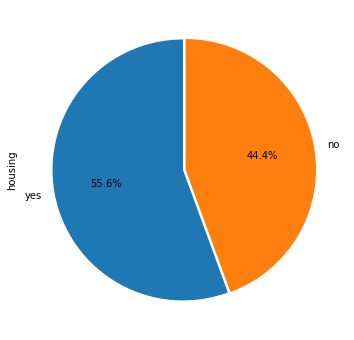

In [83]:
# Visualizing "pie" graph
data_cat_t['housing'].value_counts(dropna=False).plot(kind='pie', 
                                              explode = (0.01, 0.01), 
                                              figsize=(10,6), 
                                              autopct='%1.1f%%',
                                              startangle=90);
print(f"Unique values: {data_cat_t.housing.nunique()}")
print("")

there is no unknown variable

Encoded by dummies method and numeric tranformation

In [84]:
# housing
data_housing = data_cat_t.housing
housing_ohe = pd.get_dummies(data_housing)
binary_encoder_housing = BinaryEncoder()
housing_bin = binary_encoder_housing.fit_transform(data_housing)
print(f'''
*Results*
housing OHE: {marital_ohe.shape[1]} columns''')


*Results*
housing OHE: 3 columns


In [85]:
# Removing 'housing' and concatenation housing_ohe
data_cat_t.drop(["housing"],axis=1,inplace=True)
data_cat_t = pd.concat([data_cat_t,housing_bin],axis=1)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,loan,contact,month,poutcome,age_bins,admin.,blue-collar,entrepreneur,housemaid,...,self-employed,services,student,technician,unemployed,divorced,married,single,housing_0,housing_1
0,2,no,unknown,may,unknown,Adult,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,3,no,unknown,may,unknown,Adult,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1


(45211, 22)

## Variable: loan

Unique values: 2



,Freq abs,percent %
no,37967,83.98
yes,7244,16.02


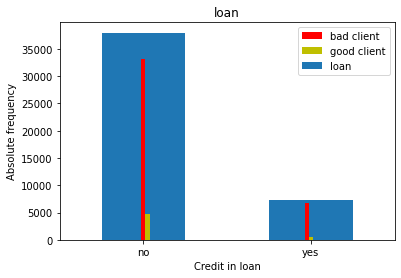

In [86]:
print(f"Unique values: {data_cat.loan.nunique()}")
print("")
# Visualizing graph "bar"
data['loan'].value_counts(dropna=False).plot(kind='bar', figsize=(6,4));
# Observations by class
loan_obs = data_cat.loan.value_counts()
loan_o = pd.DataFrame(loan_obs)
loan_o.rename(columns={"loan":"Freq abs"}, inplace=True)
loan_o_pc = (data_cat.loan.value_counts(normalize=True) * 100).round(decimals=2)
loan_obs_pc = pd.DataFrame(loan_o_pc)
loan_obs_pc.rename(columns={"loan":"percent %"}, inplace=True)
loan_obs = pd.concat([loan_o,loan_obs_pc], axis=1)
display(loan_obs)

# Graph 'housing' vs. 'target'
loan_0 = data[data.target == 0].iloc[:,7:8]
loan_1 = data[data.target == 1].iloc[:,7:8]

a = np.array(loan_0)
b = np.array(loan_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 1, label='bad client', align="left")
plt.hist(b, bins=40, color="y", alpha = 1, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('loan', fontsize=12)
plt.xlabel('Credit in loan')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

there is no unknown variable

Encoded by dummies method and numeric tranformation

In [87]:
# loan
data_loan = data_cat_t.loan
loan_ohe = pd.get_dummies(data_loan)
binary_encoder_loan = BinaryEncoder()
loan_bin = binary_encoder_loan.fit_transform(data_loan)
print(f'''
*Results*
loan OHE: {loan_ohe.shape[1]} columns''')


*Results*
loan OHE: 2 columns


In [88]:
# Removing 'loan' and concatenation housing_ohe
data_cat_t.drop(["loan"],axis=1,inplace=True)
data_cat_t = pd.concat([data_cat_t,loan_bin],axis=1)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,contact,month,poutcome,age_bins,admin.,blue-collar,entrepreneur,housemaid,management,...,student,technician,unemployed,divorced,married,single,housing_0,housing_1,loan_0,loan_1
0,2,unknown,may,unknown,Adult,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,1
1,3,unknown,may,unknown,Adult,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1


(45211, 23)

## Variable poutcome

Unique values: 4



,Freq abs,percent %
unknown,36959,81.75
failure,4901,10.84
other,1840,4.07
success,1511,3.34


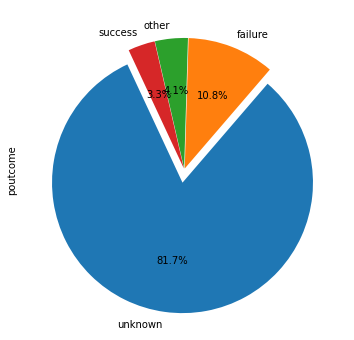

In [89]:
print(f"Unique values: {data_cat.poutcome.nunique()}")
print("")

# Graph "pie"
data['poutcome'].value_counts(dropna=False).plot(kind='pie', 
                                                figsize=(10,6), 
                                                explode = (0.1, 0.01, 0.01,0.01),
                                                autopct='%1.1f%%',
                                                startangle=115);

# Number of observation by class
pout_obs = data.poutcome.value_counts()
pout_o = pd.DataFrame(pout_obs)
pout_o.rename(columns={"poutcome":"Freq abs"}, inplace=True)
pout_o_pc = (data.poutcome.value_counts(normalize=True) * 100).round(decimals=2)
pout_obs_pc = pd.DataFrame(pout_o_pc)
pout_obs_pc.rename(columns={"poutcome":"percent %"}, inplace=True)
pout_obs = pd.concat([pout_o,pout_obs_pc], axis=1)
pout_obs

In this case, 'unknown' values are interpreted as relevant values.

Strategy: No transformation.
Encoded by dummies method and numeric tranformation

In [90]:
# Encoding 'poutcome' OHE
data_poutcome = data_cat_t.poutcome
poutcome_ohe = pd.get_dummies(data_poutcome)
binary_encoder_poutcome = BinaryEncoder()
poutcome_bin = binary_encoder_poutcome.fit_transform(data_poutcome)
print(f'''
*Results*
poutcome OHE: {poutcome_ohe.shape[1]} columns''')


*Results*
poutcome OHE: 4 columns


In [91]:
# Remove 'poutcome' and concatenation poutcome_ohe
data_cat_t.drop(["poutcome"],axis=1,inplace=True)
data_cat_t = pd.concat([data_cat_t,poutcome_ohe],axis=1)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,contact,month,age_bins,admin.,blue-collar,entrepreneur,housemaid,management,retired,...,married,single,housing_0,housing_1,loan_0,loan_1,failure,other,success,unknown
0,2,unknown,may,Adult,0,0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1
1,3,unknown,may,Adult,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,1


(45211, 26)

## Variable Month

Unique values: 12



,Freq abs,percent %
may,13766,30.45
jul,6895,15.25
aug,6247,13.82
jun,5341,11.81
nov,3970,8.78
apr,2932,6.49
feb,2649,5.86
jan,1403,3.10
oct,738,1.63
sep,579,1.28


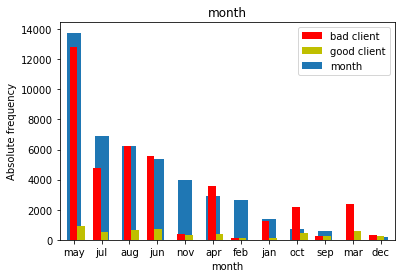

In [92]:
print(f"Unique values: {data.month.nunique()}")
print("")

# Visualizing graph "bar"
data['month'].value_counts(dropna=False).plot(kind='bar', figsize=(6,4));

# Number of observations by class
month_obs = data.month.value_counts()
month_o = pd.DataFrame(month_obs)
month_o.rename(columns={"month":"Freq abs"}, inplace=True)
month_o_pc = (data.month.value_counts(normalize=True) * 100).round(decimals=2)
month_obs_pc = pd.DataFrame(month_o_pc)
month_obs_pc.rename(columns={"month":"percent %"}, inplace=True)
month_obs = pd.concat([month_o,month_obs_pc], axis=1)
display(month_obs)


# Graph 'month' vs. 'target'
month_0 = data[data.target == 0].iloc[:,10:11]
month_1 = data[data.target == 1].iloc[:,10:11]

a = np.array(month_0)
b = np.array(month_1)

np.warnings.filterwarnings('ignore')

plt.hist(a, bins=40, color="r", alpha = 1, label='bad client', align="left")
plt.hist(b, bins=40, color="y", alpha = 1, label='good client', align="right")
plt.legend(loc='upper right')
plt.title('month', fontsize=12)
plt.xlabel('month')
plt.xticks(rotation='horizontal')
plt.ylabel('Absolute frequency')
plt.show()

there is no unknown value. Again, displaying the results of how many extra columns both One Hot Encoding and Binary Encoding would create with the encoding procedure.

In [93]:
# Encoding 'month' OHE
data_month = data_cat_t.month
month_ohe = pd.get_dummies(data_month)
binary_encoder_month = BinaryEncoder()
month_bin = binary_encoder_month.fit_transform(data_month)
print(f'''
*Results*
month OHE: {month_ohe.shape[1]} columns''')


*Results*
month OHE: 12 columns


In [94]:
# Remove 'month' and concatenation month_ohe
data_cat_t.drop(["month"],axis=1,inplace=True)
data_cat_t = pd.concat([data_cat_t,month_ohe],axis=1)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,contact,age_bins,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,2,unknown,Adult,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3,unknown,Adult,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


(45211, 37)

### Variable Contact

In [95]:
print(f"Unique values: {data_cat.contact.nunique()}")
print("")

# Observations by class
num_obs = data_cat.contact.value_counts()
num_o = pd.DataFrame(num_obs)
num_o.rename(columns={"contact":"Freq abs"}, inplace=True)
num_o_pc = (data_cat.contact.value_counts(normalize=True) * 100).round(decimals=2)
num_obs_pc = pd.DataFrame(num_o_pc)
num_obs_pc.rename(columns={"contact":"percent %"}, inplace=True)
n_obs = pd.concat([num_o,num_obs_pc], axis=1)
display(n_obs)

Unique values: 3



,Freq abs,percent %
cellular,29285,64.77
unknown,13020,28.80
telephone,2906,6.43


Unique values: 2



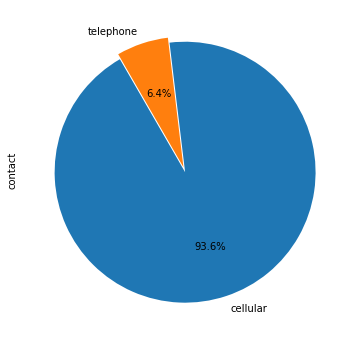

In [96]:
# Replacing 'unknown' by NaN
data_cat_t.contact.replace(to_replace="unknown", value=np.nan, inplace=True)

# Imputation of missing values by modal value
data_cat_t['contact'] = data_cat_t.contact.fillna(data_cat_t.contact.value_counts().index[0])

# Graph "pie"
data_cat_t['contact'].value_counts(dropna=False).plot(kind='pie', figsize=(10,6),
                                              explode = (0.02, 0.02),
                                              autopct='%1.1f%%',
                                              startangle=120);
print(f"Unique values: {data_cat_t.contact.nunique()}")
print("")

In [97]:
# Encoding 'contact' OHE
data_contact = data_cat_t.contact
contact_ohe = pd.get_dummies(data_contact)
binary_encoder_contact = BinaryEncoder()
contact_bin = binary_encoder_contact.fit_transform(data_contact)
print(f'''
*Results*
contact OHE: {contact_ohe.shape[1]} columns''')


*Results*
contact OHE: 2 columns


In [98]:
# Remove 'contact' and concatenation contact_ohe
data_cat_t.drop(["contact"],axis=1,inplace=True)
data_cat_t = pd.concat([data_cat_t,contact_ohe],axis=1)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,age_bins,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,...,jan,jul,jun,mar,may,nov,oct,sep,cellular,telephone
0,2,Adult,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,3,Adult,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


(45211, 38)

In [99]:
data_cat_t.drop(["age_bins"], axis=1, inplace=True)
display(data_cat_t.head(2))
display(data_cat_t.shape)

,education,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,...,jan,jul,jun,mar,may,nov,oct,sep,cellular,telephone
0,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


(45211, 37)

In [100]:
data_cat_t.dtypes

education        int64
admin.           uint8
blue-collar      uint8
entrepreneur     uint8
housemaid        uint8
management       uint8
retired          uint8
self-employed    uint8
services         uint8
student          uint8
technician       uint8
unemployed       uint8
divorced         uint8
married          uint8
single           uint8
housing_0        int64
housing_1        int64
loan_0           int64
loan_1           int64
failure          uint8
other            uint8
success          uint8
unknown          uint8
apr              uint8
aug              uint8
dec              uint8
feb              uint8
jan              uint8
jul              uint8
jun              uint8
mar              uint8
may              uint8
nov              uint8
oct              uint8
sep              uint8
cellular         uint8
telephone        uint8
dtype: object

In [101]:
# Analysis of the transformed dataset
display(data_cat_t.dtypes)
print("")
print(f"data_cat (original): ........ {data_cat.shape}")
print(f"data_cat_t (transformed): ... {data_cat_t.shape}")

education        int64
admin.           uint8
blue-collar      uint8
entrepreneur     uint8
housemaid        uint8
management       uint8
retired          uint8
self-employed    uint8
services         uint8
student          uint8
technician       uint8
unemployed       uint8
divorced         uint8
married          uint8
single           uint8
housing_0        int64
housing_1        int64
loan_0           int64
loan_1           int64
failure          uint8
other            uint8
success          uint8
unknown          uint8
apr              uint8
aug              uint8
dec              uint8
feb              uint8
jan              uint8
jul              uint8
jun              uint8
mar              uint8
may              uint8
nov              uint8
oct              uint8
sep              uint8
cellular         uint8
telephone        uint8
dtype: object


data_cat (original): ........ (45211, 10)
data_cat_t (transformed): ... (45211, 37)


In [102]:
# Concatenation of both numeric and categorical datasets
data_numcat = pd.concat([data_cat_t,data_num], axis=1)

# Removing any NaNs or anomalies just to make sure
data_numcat.dropna(how="any", axis=0)


,education,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,...,cellular,telephone,age,balance,day,duration,campaign,pdays,previous,target
0,2,0,0,0,0,1,0,0,0,0,...,1,0,58,2143,5,261,1,-1,0,0
1,3,0,0,0,0,0,0,0,0,0,...,1,0,44,29,5,151,1,-1,0,0
2,3,0,0,1,0,0,0,0,0,0,...,1,0,33,2,5,76,1,-1,0,0
3,3,0,1,0,0,0,0,0,0,0,...,1,0,47,1506,5,92,1,-1,0,0
4,3,0,1,0,0,0,0,0,0,0,...,1,0,33,1,5,198,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,2,0,0,0,0,0,0,0,0,0,...,1,0,51,825,17,977,3,-1,0,1
45207,1,0,0,0,0,0,1,0,0,0,...,1,0,71,1729,17,456,2,-1,0,1
45208,3,0,0,0,0,0,1,0,0,0,...,1,0,72,5715,17,1127,5,184,3,1
45209,3,0,1,0,0,0,0,0,0,0,...,0,1,57,668,17,508,4,-1,0,0


In [103]:
# Subdivision of the target
y_numcat = data_numcat.target
X_numcat = data_numcat.drop(["target"], axis= "columns")

In [104]:
# Identifying all variables with great predictive power (Pearson Correlation p-value)
dataframe = pd.DataFrame(
    [scipy.stats.pearsonr(X_numcat[col], y_numcat) for col in X_numcat.columns],
    columns=["Pearson Corr.", "p-value"],
    index=X_numcat.columns,
).round(2).sort_values(by="p-value", ascending=False)

display(dataframe)

,Pearson Corr.,p-value
self-employed,0.00,0.86
education,-0.00,0.71
divorced,0.00,0.56
admin.,0.01,0.23
aug,-0.01,0.07
jan,-0.01,0.06
technician,-0.01,0.06
failure,0.01,0.04
nov,-0.01,0.00
feb,0.04,0.00


In [105]:
# Identifying columns in which p-value > 0.05
column = []
for item in dataframe.index:
    if dataframe['p-value'][item] > 0.05 or dataframe['p-value'][item] == 'NaN':
        column.append(item)

In [106]:
# Removing statistically non significant columns
data_numcat.drop(column, axis=1, inplace=True)

In [107]:
data_numcat.shape

(45211, 38)

## Determine the baseline
### Clients definition:
### TP = Good candidates identified as good candidates
### TN = Bad candidates identified as bad candidates
### FP = Bad candidates identified as good candidates
### FN = Good candidates identified as bad candidates
### Real scenario:
### Clients who has subscribed the term deposit: 39922
### Clients who hasn't subscribed the term deposit:   5289

In [108]:
# Dividing the numeric dataset (df_num) in train (80%) and test (20%)
train_set, test_set = train_test_split(data_numcat, test_size = 0.2, random_state = seed)

X_train = train_set.drop(['target'], axis = 'columns')
y_train = train_set['target']

X_test = test_set.drop(['target'], axis = 1)
y_test = test_set['target']

### Assuming all bad customers

In [109]:
y_preds_all_bad = np.zeros(y_test.shape)
y_preds_all_bad

array([0., 0., 0., ..., 0., 0., 0.])

In [110]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print(f'''
Number of True Negatives: {tn}
Number of True Positives: {tp}
Number of False Negatives: {fn}
Number of False Positives: {fp}
''')

print(confusion_matrix(y_test, y_preds_all_bad))




Number of True Negatives: 7986
Number of True Positives: 0
Number of False Negatives: 1057
Number of False Positives: 0

[[7986    0]
 [1057    0]]


#### Assuming all good customers

In [111]:
y_preds_all_good = np.ones(y_test.shape)
y_preds_all_good

array([1., 1., 1., ..., 1., 1., 1.])

In [112]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print("")
print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)
print("")
print(confusion_matrix(y_test, y_preds_all_good))



Number of True Negatives: 0
Number of True Positives: 1057
Number of False Negatives: 0
Number of False Positives: 7986

[[   0 7986]
 [   0 1057]]


### ROC Curve: Area Under the Curve

In [113]:
# ROC Curve: Area Under the Curve

def auc_roc_plot(y_test, y_preds):

    fpr, tpr, thresholds = roc_curve(y_test,y_preds)
    roc_auc = auc(fpr, tpr)
    
    print(roc_auc)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Modelling
### Logistic Regression (LR)

In [114]:
# Making a copy of the dataset (df_num)
data_rl = data_numcat.copy()

In [115]:
# Dividing the dataset in train (80%) and test (20%)
train_set_rl, test_set_rl = train_test_split(data_rl, test_size = 0.2, random_state = seed)

X_train_rl = train_set_rl.drop(['target'], axis = 1)
y_train_rl = train_set_rl['target']

X_test_rl = test_set_rl.drop(['target'], axis = 1)
y_test_rl = test_set_rl['target']

In [116]:
# Normalization of the train and test data
scaler_rl = MinMaxScaler()
features_names = X_train_rl.columns

X_train_rl = scaler_rl.fit_transform(X_train_rl)
X_train_rl = pd.DataFrame(X_train_rl, columns = features_names)

X_test_rl = scaler_rl.transform(X_test_rl)
X_test_rl = pd.DataFrame(X_test_rl, columns = features_names) 

In [117]:
%%time
lr = LogisticRegression(max_iter = 500, solver = 'lbfgs', random_state = seed, class_weight = 'balanced' )

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}

clf_lr = GridSearchCV(lr, parameters, cv = 5).fit(X_train_rl, y_train_rl)

Wall time: 24.8 s


In [118]:
clf_lr

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          random_state=123),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [119]:
clf_lr.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', max_iter=500,
                   random_state=123)

In [120]:
clf_lr.best_estimator_.C

0.1

In [121]:
clf_lr.best_score_

0.8429827831543909

0.8999856892418875


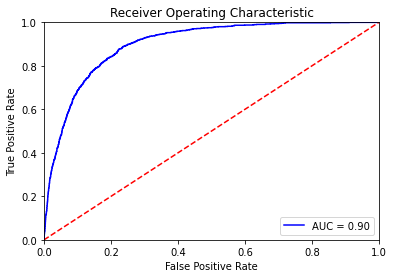

In [122]:
y_preds_rl = clf_lr.predict_proba(X_test_rl)[:,1]
auc_roc_plot(y_test_rl, y_preds_rl)

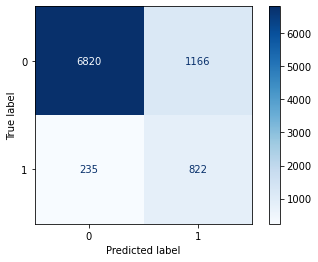

In [123]:
# Confusion Matrix display
plot_confusion_matrix(clf_lr, X_test_rl, y_test_rl, values_format=".4g", cmap="Blues");

# Creates assignments for Final Results
tn, fp, fn, tp = confusion_matrix(y_test_rl == 1, y_preds_rl > 0.5).ravel()
tn_lr = tn
fp_lr = fp
fn_lr = fn
tp_lr = tp

### K Nearest Neighbor (KNN)

In [124]:
# Making a copy of the dataset
data_knn = data_numcat.copy()

In [125]:
# Dividing the dataset in train (80%) and test (20%)
train_set_knn, test_set_knn = train_test_split(data_knn, test_size = 0.2, random_state = seed)

X_train_knn = train_set_knn.drop(['target'], axis = 1)
y_train_knn = train_set_knn['target']

X_test_knn = test_set_knn.drop(['target'], axis = 1)
y_test_knn = test_set_knn['target']

In [126]:
# Normalizing train and test data
scaler_knn = MinMaxScaler()
features_names = X_train_knn.columns

X_train_knn = scaler_knn.fit_transform(X_train_knn)
X_train_knn = pd.DataFrame(X_train_knn, columns = features_names)

X_test_knn = scaler_knn.transform(X_test_knn)
X_test_knn = pd.DataFrame(X_test_knn, columns = features_names)

In [127]:
%%time
for k in range(1, 200, 5):

  k = k + 1

  knn = KNeighborsClassifier(n_neighbors = k).fit(X_train_knn, y_train_knn)

  acc = knn.score(X_test_knn, y_test_knn)

  print('Accuracy for k =', k, ' is:', acc)

Accuracy for k = 2  is: 0.886431493973239
Accuracy for k = 7  is: 0.8915183014486343
Accuracy for k = 12  is: 0.8891960632533451
Accuracy for k = 17  is: 0.8925135463894726
Accuracy for k = 22  is: 0.8920712153046555
Accuracy for k = 27  is: 0.8932876257879022
Accuracy for k = 32  is: 0.8935087913303107
Accuracy for k = 37  is: 0.8937299568727193
Accuracy for k = 42  is: 0.8932876257879022
Accuracy for k = 47  is: 0.8930664602454937
Accuracy for k = 52  is: 0.8932876257879022
Accuracy for k = 57  is: 0.8932876257879022
Accuracy for k = 62  is: 0.8928452947030853
Accuracy for k = 67  is: 0.8928452947030853
Accuracy for k = 72  is: 0.8924029636182683
Accuracy for k = 77  is: 0.8924029636182683
Accuracy for k = 82  is: 0.891850049762247
Accuracy for k = 87  is: 0.8916288842198385
Accuracy for k = 92  is: 0.8908548048214088
Accuracy for k = 97  is: 0.8909653875926131
Accuracy for k = 102  is: 0.8907442220502045
Accuracy for k = 107  is: 0.8905230565077961
Accuracy for k = 112  is: 0.890191

In [128]:
%%time
knn = KNeighborsClassifier(n_neighbors = 37, weights='uniform').fit(X_train_knn, y_train_knn)

y_preds_knn = knn.predict(X_test_knn)

accuracy_score(y_test_knn, y_preds_knn)

Wall time: 27.6 s


0.8937299568727193

In [129]:
y_preds_knn = knn.predict_proba(X_test_knn)[:,1]

knn.score(X_test_knn, y_test_knn)

0.8937299568727193

0.8107402239633645


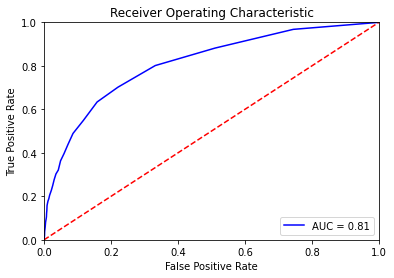

In [130]:
auc_roc_plot(y_test_knn, y_preds_knn)

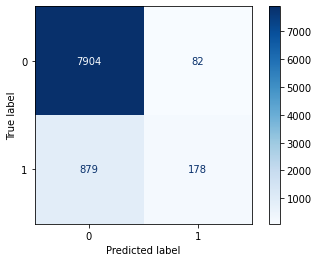

In [131]:
# Confusion Matrix display
plot_confusion_matrix(knn, X_test_knn, y_test_knn, values_format=".4g", cmap="Blues");

# Creates assignments for Final Results
tn, fp, fn, tp = confusion_matrix(y_test_knn == 1, y_preds_knn > 0.5).ravel()
tn_knn = tn
fp_knn = fp
fn_knn = fn
tp_knn = tp

## Support Vector Machine (SVM)

In [132]:
# Making a copy of the dataset
data_svm = data_numcat.copy()

In [133]:
# Dividing the dataset in train (80%) and test (20%)
train_set_svm, test_set_svm = train_test_split(data_svm, test_size = 0.2, random_state = seed)

X_train_svm = train_set_svm.drop(['target'], axis = 1)
y_train_svm = train_set_svm['target']

X_test_svm = test_set_svm.drop(['target'], axis = 1)
y_test_svm = test_set_svm['target']

In [134]:
# Standardization of train and test data
zscore_svm = StandardScaler()
features_names = X_train_svm.columns

X_train_svm = zscore_svm.fit_transform(X_train_svm)
X_train_svm = pd.DataFrame(X_train_svm, columns = features_names)

X_test_svm = zscore_svm.transform(X_test_svm)
X_test_svm = pd.DataFrame(X_test_svm, columns = features_names)


In [193]:
%%time
svm = SVC(random_state=seed, class_weight='balanced',probability=True, verbose=True)

parameters = {'kernel':['rbf'],'C':[0.1, 1, 10]}

clf_svm = GridSearchCV(svm, parameters, refit = True, cv = 5).fit(X_train_svm, y_train_svm)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Wall time: 1h 50min 44s


In [194]:
clf_svm

GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=123, verbose=True),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf']})

In [195]:
clf_svm.best_estimator_

SVC(C=10, class_weight='balanced', probability=True, random_state=123,
    verbose=True)

In [196]:
clf_svm.best_estimator_.C

10

In [197]:
%%time
y_preds_svm = clf_svm.predict_proba(X_test_svm)[:,1]

clf_svm.score(X_test_svm, y_test_svm)

Wall time: 25.3 s


0.8485016034501824

0.8949071471100918


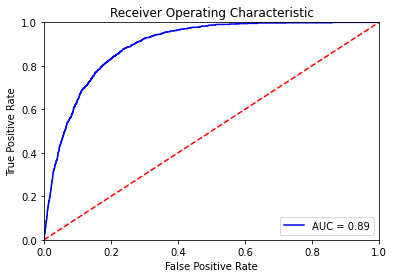

In [198]:
auc_roc_plot(y_test_svm, y_preds_svm)

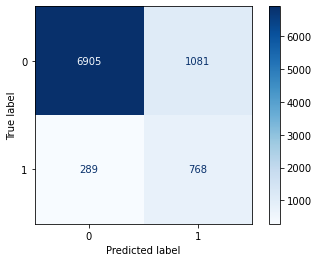

In [199]:
# Confusion Matrix display
plot_confusion_matrix(clf_svm, X_test_svm, y_test_svm, values_format=".4g", cmap="Blues");

# Creates assignments for Final Results
tn, fp, fn, tp = confusion_matrix(y_test_svm == 1, y_preds_svm > 0.5).ravel()
tn_svm = tn
fp_svm = fp
fn_svm = fn
tp_svm = tp


## Decision Trees (DT)

In [140]:
# Making a copy
data_trees = data_numcat.copy()

In [141]:
# Dividing the dataset in train (80%) and test (20%)
train_set_dt, test_set_dt = train_test_split(data_trees, test_size = 0.2, random_state = seed)

X_train_dt = train_set_dt.drop(['target'], axis = 1)
y_train_dt = train_set_dt['target']

X_test_dt = test_set_dt.drop(['target'], axis = 1)
y_test_dt = test_set_dt['target']

In [142]:
%%time
clf_tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 8).fit(X_train_dt, y_train_dt)

Wall time: 153 ms


In [143]:
clf_tree.score(X_test_dt, y_test_dt)

0.9016919163994249

In [144]:
dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,  
                filled = True, rounded = True,
                special_characters = True, feature_names = X_train_dt.columns,class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [145]:
clf_tree.feature_importances_

array([1.67300877e-03, 8.73104864e-04, 0.00000000e+00, 7.98792480e-04,
       5.29154463e-04, 0.00000000e+00, 1.70064252e-03, 0.00000000e+00,
       5.45680221e-03, 2.16496496e-03, 1.92532171e-02, 1.30512032e-02,
       2.12419284e-03, 0.00000000e+00, 1.76120426e-03, 0.00000000e+00,
       2.31977922e-01, 0.00000000e+00, 6.06934357e-03, 6.00363535e-04,
       3.06090788e-04, 2.95654708e-03, 4.65655928e-04, 3.82311021e-02,
       3.18443081e-03, 1.32890678e-03, 2.64797610e-02, 1.51047704e-03,
       0.00000000e+00, 5.23862919e-04, 5.87327032e-02, 1.87508433e-02,
       2.29115893e-02, 4.79159787e-01, 3.93585648e-03, 4.73573720e-02,
       6.13109809e-03])

In [146]:
# Listing feature importance
list(zip(data_numcat.columns, clf_tree.feature_importances_))

[('blue-collar', 0.0016730087681064599),
 ('entrepreneur', 0.0008731048643743059),
 ('housemaid', 0.0),
 ('management', 0.0007987924804290636),
 ('retired', 0.0005291544632571553),
 ('services', 0.0),
 ('student', 0.0017006425224986724),
 ('unemployed', 0.0),
 ('married', 0.005456802205158143),
 ('single', 0.002164964961764068),
 ('housing_0', 0.019253217139232448),
 ('housing_1', 0.01305120316830544),
 ('loan_0', 0.00212419284253712),
 ('loan_1', 0.0),
 ('failure', 0.0017612042598695724),
 ('other', 0.0),
 ('success', 0.23197792158615282),
 ('unknown', 0.0),
 ('apr', 0.006069343565485471),
 ('dec', 0.0006003635353126185),
 ('feb', 0.00030609078783558813),
 ('jul', 0.0029565470752001325),
 ('jun', 0.0004656559276662967),
 ('mar', 0.03823110211899809),
 ('may', 0.0031844308087261393),
 ('nov', 0.0013289067842177551),
 ('oct', 0.026479761003228096),
 ('sep', 0.0015104770446703498),
 ('cellular', 0.0),
 ('telephone', 0.0005238629186245838),
 ('age', 0.058732703246923965),
 ('balance', 0.0

In [147]:
# Visualizing variables by importance
important_features = pd.DataFrame(data = clf_tree.feature_importances_, index = X_train_dt.columns, columns = ["value"])
important_features.sort_values(by = "value", ascending = False)

,value
duration,0.479160
success,0.231978
age,0.058733
pdays,0.047357
mar,0.038231
oct,0.026480
day,0.022912
housing_0,0.019253
balance,0.018751
housing_1,0.013051


In [148]:
y_preds_dt = clf_tree.predict_proba(X_test_dt)[:,1]

clf_tree.score(X_test_dt, y_test_dt)

0.9016919163994249

0.8620403231672457


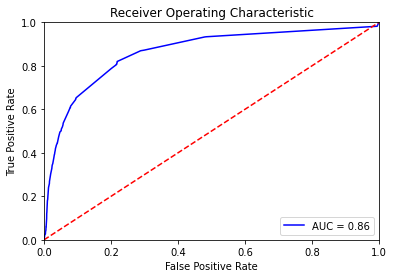

In [149]:
auc_roc_plot(y_test_dt, y_preds_dt)

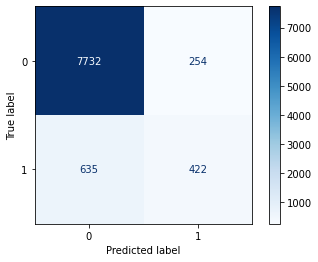

In [150]:
# Confusion Matrix display
plot_confusion_matrix(clf_tree, X_test_dt, y_test_dt, values_format=".4g", cmap="Blues");

# Creates assignments Final Results
tn, fp, fn, tp = confusion_matrix(y_test_dt == 1, y_preds_dt > 0.5).ravel()
tn_dt = tn
fp_dt = fp
fn_dt = fn
tp_dt = tp

## Random Forest (RF)

In [151]:
# Makes a copy
data_rf = data_numcat.copy()

In [152]:
# Dividing the dataset in train (80%) and test (20%)
train_set_rf, test_set_rf = train_test_split(data_rf, test_size = 0.2, random_state = seed)

X_train_rf = train_set_rf.drop(['target'], axis = 1)
y_train_rf = train_set_rf['target']

X_test_rf = test_set_rf.drop(['target'], axis = 1)
y_test_rf = test_set_rf['target']

In [153]:
%%time 
rf = RandomForestClassifier(random_state = seed, class_weight = None).fit(X_train_rf, y_train_rf)

parameters = {'n_estimators':[10, 100, 300, 1000]}

clf_rf = GridSearchCV(rf, parameters, cv = 5).fit(X_train_rf, y_train_rf)

Wall time: 4min 5s


In [154]:
clf_rf

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'n_estimators': [10, 100, 300, 1000]})

In [155]:
clf_rf.best_estimator_

RandomForestClassifier(n_estimators=1000, random_state=123)

In [157]:
y_preds_rf = clf_rf.predict_proba(X_test_rf)[:,1]
clf_rf.score(X_test_rf, y_test_rf)

0.9037929890523057

0.9211156776013653


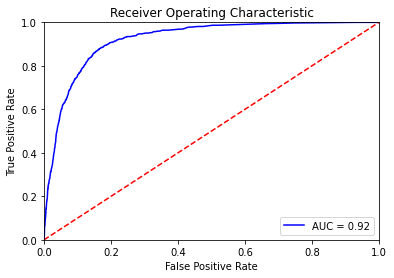

In [158]:
auc_roc_plot(y_test_rf, y_preds_rf)

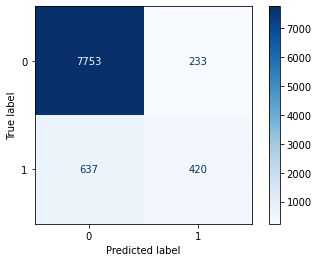

In [159]:
# Confusion Matrxi display
plot_confusion_matrix(clf_rf, X_test_rf, y_test_rf, values_format=".4g", cmap="Blues");

# Creates assignments for Final Results
tn, fp, fn, tp = confusion_matrix(y_test_rf == 1, y_preds_rf > 0.5).ravel()
tn_rf = tn
fp_rf = fp
fn_rf = fn
tp_rf = tp

## Neural Networks (NN)

In [160]:
# Makes a copy
data_nn = data_numcat.copy()

In [161]:
# Dividing the dataset in train (80%) and test (20%)
train_set_nn, test_set_nn = train_test_split(data_nn, test_size = 0.2, random_state = seed)

X_train_nn = train_set_nn.drop(['target'], axis = 1)
y_train_nn = train_set_nn['target']

X_test_nn = test_set_nn.drop(['target'], axis = 1)
y_test_nn = test_set_nn['target']

In [162]:
%%time
mlp_nn = MLPClassifier(solver = 'adam', random_state = seed, max_iter = 1000 )

parameters = {'hidden_layer_sizes': [(20,), (20,10), (20, 10, 2)], 'learning_rate_init':[0.0001, 0.001, 0.01, 0.1]}

clf_nn = GridSearchCV(mlp_nn, parameters, cv = 5).fit(X_train_nn, y_train_nn)

Wall time: 6min 42s


In [163]:
clf_nn

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=123),
             param_grid={'hidden_layer_sizes': [(20,), (20, 10), (20, 10, 2)],
                         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]})

In [164]:
clf_nn.best_estimator_

MLPClassifier(hidden_layer_sizes=(20,), learning_rate_init=0.0001,
              max_iter=1000, random_state=123)

In [166]:
y_preds_nn = clf_nn.predict_proba(X_test_nn)[:,1]

clf_nn.score(X_test_nn, y_test_nn)

0.8989273471193188

0.8961119518286614


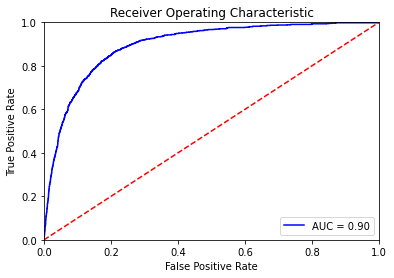

In [167]:
auc_roc_plot(y_test_nn, y_preds_nn)

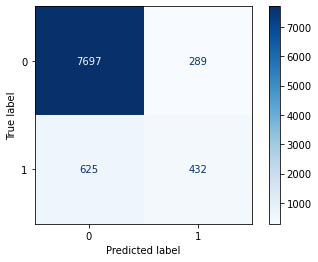

In [168]:
# Confusion Matrix display
plot_confusion_matrix(clf_nn, X_test_nn, y_test_nn, values_format=".4g", cmap="Blues");

# Creates assignments for Final Results
tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds_nn > 0.5).ravel()
tn_nn = tn
fp_nn = fp
fn_nn = fn
tp_nn = tp

In [200]:
clf_lr= float(84.30)
aucroclr = float(90)
knn= float(89.37)
aucrocknn = float(81.07)
clf_svm= float(84.85)
aucrocsvm = float(89.49)
clf_tree= float(90.17)
aucrocdt = float(86.20)
clf_rf= float(90.38)
aucrocrf = float(92.11)
clf_nn= float(89.89)
aucrocnn = float(89.61)

### Results: comparison of all models

In [201]:
# Creating performance table
results_p = {'Classifier': ['Accuracy (%)','AUC ROC (%)','TN (%)','FP (%)','FN (%)','TP (%)'],
            'Logistic Regression (LR)': [clf_lr,aucroclr,(tn_lr/9043*100).round(decimals=2),(fp_lr/9043*100).round(decimals=2),
                                         (fn_lr/9043*100).round(decimals=2),(tp_lr/9043*100).round(decimals=2)],
            'K Nearest Neighbour (KNN)': [knn,aucrocknn,(tn_knn/9043*100).round(decimals=2),(fp_knn/9043*100).round(decimals=2),
                                         (fn_knn/9043*100).round(decimals=2),(tp_knn/9043*100).round(decimals=2)],
            'Support Vector Machine (SVM)': [clf_svm,aucrocsvm,(tn_svm/9043*100).round(decimals=2),(fp_svm/9043*100).round(decimals=2),
                                         (fn_svm/9043*100).round(decimals=2),(tp_svm/9043*100).round(decimals=2)],
            'Decision Trees (DT)': [clf_tree,aucrocdt,(tn_dt/9043*100).round(decimals=2),(fp_dt/9043*100).round(decimals=2),
                                         (fn_dt/9043*100).round(decimals=2),(tp_dt/9043*100).round(decimals=2)],
            'Random Forest (RF)': [clf_rf, aucrocrf,(tn_rf/9043*100).round(decimals=2),(fp_rf/9043*100).round(decimals=2),
                                         (fn_rf/9043*100).round(decimals=2),(tp_rf/9043*100).round(decimals=2)],
            'Neural Networks (NN)': [clf_nn, aucrocnn, (tn_nn/9043*100).round(decimals=2),
                                     (fp_nn/9043*100).round(decimals=2),(fn_nn/9043*100).round(decimals=2),(tp_nn/9043*100).round(decimals=2)]
           }

datap = pd.DataFrame(results_p, columns = ['Classifier',
                                           'Logistic Regression (LR)',
                                           'K Nearest Neighbour (KNN)',
                                           'Support Vector Machine (SVM)',
                                           'Decision Trees (DT)',
                                           'Random Forest (RF)',
                                           'Neural Networks (NN)'])
datap.set_index("Classifier", inplace=True)

results_p = datap.T
resultsT = datap

results_p


Classifier,Accuracy (%),AUC ROC (%),TN (%),FP (%),FN (%),TP (%)
Logistic Regression (LR),84.30,90.00,75.42,12.89,2.60,9.09
K Nearest Neighbour (KNN),89.37,81.07,87.40,0.91,9.72,1.97
Support Vector Machine (SVM),84.85,89.49,86.09,2.22,8.44,3.25
Decision Trees (DT),90.17,86.20,85.50,2.81,7.02,4.67
Random Forest (RF),90.38,92.11,85.73,2.58,7.04,4.64
Neural Networks (NN),89.89,89.61,85.12,3.20,6.91,4.78
